### This notebook shows the impact performance of equal shares and utilitarian greedy for projects grouped by cost-levels, in terms of metrics of budget share, winning rate, cost representation and project representation. This plot also shows the novelty metrics performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
# use this code block to set column and row viewing size/width
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', 30)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

pd.options.display.float_format = '{:.4f}'.format

In [3]:
# read the metadata csv
pbsummary_df = pd.read_csv('../metadata.csv', delimiter=';')
pbsummary_df = pbsummary_df.drop_duplicates()
pbsummary_df

pbsummary_aarau = pd.read_csv('../metadata_aarau.csv', delimiter=';')
pbsummary_df = pd.concat([pbsummary_df, pbsummary_aarau], ignore_index=True)

pbsummary_df['subunit'].fillna(value='all', inplace=True)

In [4]:
# Get election id and vote type, so we know better to segragate approval and score votings
pbsummary_with_vote_type = pbsummary_df[['election_id', 'vote_type']]
print(pbsummary_with_vote_type.head())
print(pbsummary_with_vote_type['vote_type'].value_counts())

   election_id   vote_type
0            1  cumulative
1            2  cumulative
2            3  cumulative
3            4  cumulative
4            5  cumulative
vote_type
approval      613
cumulative    104
ordinal        95
Name: count, dtype: int64


In [5]:
# reading the projects CSV and loading to dataframe
pbprojects_df = pd.read_csv('../projects.csv', delimiter=';')
pbprojects_df.drop_duplicates(inplace=True)
print(pbprojects_df.shape)

pbprojects_aarau = pd.read_csv('../projects_aarau.csv', delimiter=';')
pbprojects_df = pd.concat([pbprojects_df, pbprojects_aarau], ignore_index=True)

# merge the column vote_type into pbprojects_df
pbprojects_df = pd.merge(pbprojects_df, pbsummary_with_vote_type, on='election_id', how='inner')
print(pbprojects_df.shape)

pbprojects_df.head()

(19077, 21)
(19110, 22)


,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,category,name,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type
0,1,France,Toulouse,ARENES,2019,1,7000,1494,215,NaN,NaN,Compostons ensemble !,NaN,NaN,1000000.0000,0.7000,True,True,True,NaN,NaN,cumulative
1,1,France,Toulouse,BELLEFONTAINE MILAN,2019,2,35000,1494,26,NaN,NaN,Panneau d'affichage électronique extérieur,NaN,NaN,1000000.0000,3.5000,False,False,False,NaN,NaN,cumulative
2,1,France,Toulouse,ARENES,2019,3,50000,1494,92,NaN,NaN,Eclairage public d’un chemin piéton-vélo rue Ella Maillart,NaN,NaN,1000000.0000,5.0000,True,False,True,NaN,NaN,cumulative
3,1,France,Toulouse,PRADETTES,2019,4,390000,1494,471,NaN,NaN,"Tous à la Ramée à vélo ! A pied, en trottinette et rollers !",NaN,NaN,1000000.0000,39.0000,False,True,False,NaN,NaN,cumulative
4,1,France,Toulouse,NEGRENEYS,2019,5,168000,1494,205,NaN,NaN,Le parc des Anges vu par ses usagers,NaN,NaN,1000000.0000,16.8000,True,True,True,NaN,NaN,cumulative


In [6]:
# Check for projects where cost of a given project is zero

print("Projects with zero costs: ", pbprojects_df[pbprojects_df['cost'] == 0])

# Currently returns a single project ID which has been commented as been removed by City Council
invalid_projects = pbprojects_df[pbprojects_df['cost'] == 0][['project_id','election_id']]
print(invalid_projects)

# Excluding that single project id by checking with particular election id and project id
valid_pbprojects_df = pbprojects_df[~(pbprojects_df['project_id'].isin(invalid_projects['project_id']) & (pbprojects_df['election_id'].isin(invalid_projects['election_id'])))]
print(pbprojects_df.shape)
print(valid_pbprojects_df.shape)

Projects with zero costs:       election_id country    unit           subunit  instance project_id  cost  \
893           72  Poland  Gdynia  Grabówek | large      2020          5     0   

     project_voters_count  votes  score category  \
893                  1511     18    NaN      NaN   

                                                        name  englishName  \
893  PROJECT WAS REMOVED BY THE CITY FOR VIOLATING THE RULES          NaN   

    target  total_budget  budget_percent  is_mes_winner  is_greedy_winner  \
893    NaN   295110.0000          0.0000           True              True   

     is_phragmen_winner  latitude  longitude vote_type  
893                True       NaN        NaN  approval  
    project_id  election_id
893          5           72
(19110, 22)
(19109, 22)


In [7]:
# There are citywide elections (unit-level); i.e. subunit is na, for such records fill na columns with values for subunit as all
valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)

# Cross checking for projects where by we have filled with subunit equalling the value 'all'
print(valid_pbprojects_df[valid_pbprojects_df['subunit'] == 'all'].shape)

(1928, 22)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_26040\2651770478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)


In [8]:
# setting up vote_percent column
print(valid_pbprojects_df.shape)
valid_pb_projects_total_selections = valid_pbprojects_df.groupby(['election_id'])['votes'].sum().reset_index()
print(valid_pb_projects_total_selections.shape)
valid_pb_projects_total_selections.rename(columns={'votes': 'total_votes_selection'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_total_selections, on='election_id', how='inner')
valid_pbprojects_df['vote_percent'] = round((valid_pbprojects_df['votes'] / valid_pbprojects_df['total_votes_selection'] * 100),3)
print(valid_pbprojects_df.shape)

(19109, 22)
(812, 2)
(19109, 24)


In [9]:
# There are citywide elections (unit-level); i.e. subunit is na, for such records fill na columns with values for subunit as all
valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)

# Cross checking for projects where by we have filled with subunit equalling the value 'all'
print(valid_pbprojects_df[valid_pbprojects_df['subunit'] == 'all'].shape)
print("Valid PB projects are: ", valid_pbprojects_df.shape)

(1928, 24)
Valid PB projects are:  (19109, 24)


In [10]:
q1_df = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(0.25).reset_index()
q1_df.rename(columns={'cost': 'q1_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(q1_df, on='election_id', how='inner')

q2_df = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(0.5).reset_index()
q2_df.rename(columns={'cost': 'q2_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(q2_df, on='election_id', how='inner')

q3_df = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(0.75).reset_index()
q3_df.rename(columns={'cost': 'q3_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(q3_df, on='election_id', how='inner')

q4_df = valid_pbprojects_df.groupby(['election_id'])['cost'].quantile(1).reset_index()
q4_df.rename(columns={'cost': 'q4_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(q4_df, on='election_id', how='inner')

In [11]:
valid_pbprojects_df.columns

Index(['election_id', 'country', 'unit', 'subunit', 'instance', 'project_id',
       'cost', 'project_voters_count', 'votes', 'score', 'category', 'name',
       'englishName', 'target', 'total_budget', 'budget_percent',
       'is_mes_winner', 'is_greedy_winner', 'is_phragmen_winner', 'latitude',
       'longitude', 'vote_type', 'total_votes_selection', 'vote_percent',
       'q1_cost', 'q2_cost', 'q3_cost', 'q4_cost'],
      dtype='object')

In [12]:
# total projects cost per election instance
total_projects_cost = valid_pbprojects_df.groupby(['election_id'])['cost'].sum().reset_index()
total_projects_cost.rename(columns={'cost': 'total_projects_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(total_projects_cost, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

total_projects_count = valid_pbprojects_df.groupby(['election_id'])['project_id'].count().reset_index()
total_projects_count.rename(columns={'project_id': 'total_projects_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(total_projects_count, on='election_id', how='inner')

# setting additional column for total project costs and count of winners for MES ang UG
# mes_winners_total_cost
mes_winners_total_cost = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
mes_winners_total_cost.rename(columns={'cost': 'mes_total_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_winners_total_cost, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

# only_mes_winners_total_cost
only_mes_winners_total_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == False)].groupby(['election_id'])['cost'].sum().reset_index()
only_mes_winners_total_cost.rename(columns={'cost': 'only_mes_total_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(only_mes_winners_total_cost, on='election_id', how='left')
print(valid_pbprojects_df.shape)

# greedy_winners_total_cost
greedy_total_winners_cost = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
greedy_total_winners_cost.rename(columns={'cost': 'greedy_total_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_total_winners_cost, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

# only_greedy_winners_total_cost
only_greedy_winners_total_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
only_greedy_winners_total_cost.rename(columns={'cost': 'only_greedy_total_winners_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(only_greedy_winners_total_cost, on='election_id', how='left')
print(valid_pbprojects_df.shape)

# mes winners total count
mes_total_winners_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
mes_total_winners_count.rename(columns={'project_id': 'mes_total_winners_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(mes_total_winners_count, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

# only_mes_winners_total_count
only_mes_winners_total_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == False)].groupby(['election_id'])['project_id'].count().reset_index()
only_mes_winners_total_count.rename(columns={'project_id': 'only_mes_total_winners_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(only_mes_winners_total_count, on='election_id', how='left')
print(valid_pbprojects_df.shape)

# greedy winners total count
greedy_total_winners_count = valid_pbprojects_df[(valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
greedy_total_winners_count.rename(columns={'project_id': 'greedy_total_winners_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(greedy_total_winners_count, on='election_id', how='inner')
print(valid_pbprojects_df.shape)

# only_greedy_winners_total_count
only_greedy_winners_total_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
only_greedy_winners_total_count.rename(columns={'project_id': 'only_greedy_total_winners_count'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(only_greedy_winners_total_count, on='election_id', how='left')
print(valid_pbprojects_df.shape)

(19109, 29)
(19109, 31)
(19109, 32)
(19109, 33)
(19109, 34)
(19109, 35)
(19109, 36)
(19109, 37)
(19109, 38)


In [13]:
for col in valid_pbprojects_df.columns:
    print(col)

election_id
country
unit
subunit
instance
project_id
cost
project_voters_count
votes
score
category
name
englishName
target
total_budget
budget_percent
is_mes_winner
is_greedy_winner
is_phragmen_winner
latitude
longitude
vote_type
total_votes_selection
vote_percent
q1_cost
q2_cost
q3_cost
q4_cost
total_projects_cost
total_projects_count
mes_total_winners_cost
only_mes_total_winners_cost
greedy_total_winners_cost
only_greedy_total_winners_cost
mes_total_winners_count
only_mes_total_winners_count
greedy_total_winners_count
only_greedy_total_winners_count


In [14]:
# Initialize 4 different columns for labels
valid_pbprojects_df['in_first_quartile'] = 0
valid_pbprojects_df['in_second_quartile'] = 0
valid_pbprojects_df['in_third_quartile'] = 0
valid_pbprojects_df['in_fourth_quartile'] = 0

# Iterate through rows and update the new columns
for index, row in valid_pbprojects_df.iterrows():
    if row['cost'] <= row['q1_cost']:
        valid_pbprojects_df.at[index, 'in_first_quartile'] = 1
    elif row['cost'] > row['q1_cost'] and row['cost'] <= row['q2_cost']:
        valid_pbprojects_df.at[index, 'in_second_quartile'] = 1
    elif row['cost'] > row['q2_cost'] and row['cost'] <= row['q3_cost']:
        valid_pbprojects_df.at[index, 'in_third_quartile'] = 1
    else:
        valid_pbprojects_df.at[index, 'in_fourth_quartile'] = 1

In [15]:
valid_pbprojects_df[['project_id', 'election_id', 'country', 'cost', 'q1_cost', 'q2_cost', 'q3_cost', 'q4_cost', 'in_first_quartile', 'in_second_quartile', 'in_third_quartile', 'in_fourth_quartile']][valid_pbprojects_df['country'] == 'Switzerland']

,project_id,election_id,country,cost,q1_cost,q2_cost,q3_cost,q4_cost,in_first_quartile,in_second_quartile,in_third_quartile,in_fourth_quartile
19076,15,1000,Switzerland,3600,2300.0000,4000.0000,10000.0000,25000.0000,0,1,0,0
19077,30,1000,Switzerland,10000,2300.0000,4000.0000,10000.0000,25000.0000,0,0,1,0
19078,4,1000,Switzerland,20000,2300.0000,4000.0000,10000.0000,25000.0000,0,0,0,1
19079,21,1000,Switzerland,4000,2300.0000,4000.0000,10000.0000,25000.0000,0,1,0,0
19080,22,1000,Switzerland,15000,2300.0000,4000.0000,10000.0000,25000.0000,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
19104,18,1000,Switzerland,5000,2300.0000,4000.0000,10000.0000,25000.0000,0,0,1,0
19105,17,1000,Switzerland,3500,2300.0000,4000.0000,10000.0000,25000.0000,0,1,0,0
19106,27,1000,Switzerland,4000,2300.0000,4000.0000,10000.0000,25000.0000,0,1,0,0
19107,19,1000,Switzerland,500,2300.0000,4000.0000,10000.0000,25000.0000,1,0,0,0


In [16]:
cost_quartiles_set = ['first_quartile', 'second_quartile', 'third_quartile', 'fourth_quartile']

for cost_quartile in cost_quartiles_set:
    
    # total projects cost per election instance
    cost_quartile_total_projects_cost = valid_pbprojects_df[valid_pbprojects_df[f'in_{cost_quartile}'] == True].groupby(['election_id'])['cost'].sum().reset_index()
    cost_quartile_total_projects_cost.rename(columns={'cost': f'{cost_quartile}_total_projects_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_total_projects_cost, on='election_id', how='left')

    # fill N/A with 0 for those instances in which there is no project lying in such cost quartile
    valid_pbprojects_df[f'{cost_quartile}_total_projects_cost'].fillna(0, inplace=True)

    # total projects count
    cost_quartile_total_projects_count = valid_pbprojects_df[valid_pbprojects_df[f'in_{cost_quartile}'] == True].groupby(['election_id'])['project_id'].count().reset_index()
    cost_quartile_total_projects_count.rename(columns={'project_id': f'{cost_quartile}_total_projects_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_total_projects_count, on='election_id', how='left')

    valid_pbprojects_df[f'{cost_quartile}_total_projects_count'].fillna(0, inplace=True)

    # setting additional column for total project costs and count of winners for MES ang UG
    # mes_winners_total_cost
    cost_quartile_mes_winners_total_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    cost_quartile_mes_winners_total_cost.rename(columns={'cost': f'{cost_quartile}_mes_winners_total_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_mes_winners_total_cost, on='election_id', how='left')

    valid_pbprojects_df[f'{cost_quartile}_mes_winners_total_cost'].fillna(0, inplace=True)

    # only_mes_winners_total_cost
    cost_quartile_only_mes_winners_total_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == False) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    cost_quartile_only_mes_winners_total_cost.rename(columns={'cost': f'{cost_quartile}_only_mes_winners_total_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_only_mes_winners_total_cost, on='election_id', how='left')

    valid_pbprojects_df[f'{cost_quartile}_only_mes_winners_total_cost'].fillna(0, inplace=True)

    # greedy_winners_total_cost
    cost_quartile_greedy_total_winners_cost = valid_pbprojects_df[(valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    cost_quartile_greedy_total_winners_cost.rename(columns={'cost': f'{cost_quartile}_greedy_total_winners_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_greedy_total_winners_cost, on='election_id', how='left')
    valid_pbprojects_df[f'{cost_quartile}_greedy_total_winners_cost'].fillna(0, inplace=True)

    # only_greedy_winners_total_cost
    cost_quartile_only_greedy_winners_total_cost = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['cost'].sum().reset_index()
    cost_quartile_only_greedy_winners_total_cost.rename(columns={'cost': f'{cost_quartile}_only_greedy_winners_total_cost'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_only_greedy_winners_total_cost, on='election_id', how='left')
    valid_pbprojects_df[f'{cost_quartile}_only_greedy_winners_total_cost'].fillna(0, inplace=True)

    # mes winners total count
    cost_quartile_mes_total_winners_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    cost_quartile_mes_total_winners_count.rename(columns={'project_id': f'{cost_quartile}_mes_total_winners_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_mes_total_winners_count, on='election_id', how='left')
    valid_pbprojects_df[f'{cost_quartile}_mes_total_winners_count'].fillna(0, inplace=True)

    # only_mes_winners_total_count
    cost_quartile_only_mes_winners_total_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == True) & (valid_pbprojects_df['is_greedy_winner'] == False) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    cost_quartile_only_mes_winners_total_count.rename(columns={'project_id': f'{cost_quartile}_only_mes_winners_total_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_only_mes_winners_total_count, on='election_id', how='left')
    valid_pbprojects_df[f'{cost_quartile}_only_mes_winners_total_count'].fillna(0, inplace=True)

    # greedy winners total count
    cost_quartile_greedy_total_winners_count = valid_pbprojects_df[(valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    cost_quartile_greedy_total_winners_count.rename(columns={'project_id': f'{cost_quartile}_greedy_total_winners_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_greedy_total_winners_count, on='election_id', how='left')
    valid_pbprojects_df[f'{cost_quartile}_greedy_total_winners_count'].fillna(0, inplace=True)

    # only_greedy_winners_total_count
    cost_quartile_only_greedy_winners_total_count = valid_pbprojects_df[(valid_pbprojects_df['is_mes_winner'] == False) & (valid_pbprojects_df['is_greedy_winner'] == True) & (valid_pbprojects_df[f'in_{cost_quartile}'] == True)].groupby(['election_id'])['project_id'].count().reset_index()
    cost_quartile_only_greedy_winners_total_count.rename(columns={'project_id': f'{cost_quartile}_only_greedy_winners_total_count'}, inplace=True)
    valid_pbprojects_df = valid_pbprojects_df.merge(cost_quartile_only_greedy_winners_total_count, on='election_id', how='left')
    valid_pbprojects_df[f'{cost_quartile}_only_greedy_winners_total_count'].fillna(0, inplace=True)

valid_pbprojects_df.shape

(19109, 82)

### Measures for budget share and winning rate

In [17]:
oneD_to_twoD_map = {
    0: [0,0],
    1: [0,1],
    2: [1,0],
    3: [1,1]
}

cost_quartile_map = {
    'first_quartile': 'V. Cheap',
    'second_quartile': 'Cheap',
    'third_quartile': 'Expensive',
    'fourth_quartile': 'V. Expensive'
}

# relative winners based on cost quartiles
for cost_quartile in cost_quartiles_set:
    valid_pbprojects_df[f'greedy_relative_winners_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_greedy_total_winners_cost'] / valid_pbprojects_df['greedy_total_winners_cost']
    valid_pbprojects_df[f'mes_relative_winners_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_mes_winners_total_cost'] / valid_pbprojects_df['mes_total_winners_cost']
    valid_pbprojects_df[f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_winners_cost_pct_{cost_quartile}'] - valid_pbprojects_df[f'mes_relative_winners_cost_pct_{cost_quartile}']

    valid_pbprojects_df[f'greedy_relative_winners_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_greedy_total_winners_count'] / valid_pbprojects_df['greedy_total_winners_count']
    valid_pbprojects_df[f'mes_relative_winners_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_mes_total_winners_count'] / valid_pbprojects_df['mes_total_winners_count']
    valid_pbprojects_df[f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_winners_count_pct_{cost_quartile}'] - valid_pbprojects_df[f'mes_relative_winners_count_pct_{cost_quartile}']
    
    valid_pbprojects_df[f'only_greedy_relative_winners_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_greedy_winners_total_cost'] / valid_pbprojects_df['greedy_total_winners_cost']
    valid_pbprojects_df[f'only_mes_relative_winners_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_mes_winners_total_cost'] / valid_pbprojects_df['mes_total_winners_cost']
    valid_pbprojects_df[f'diff_go_mo_relative_winners_cost_pct_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_winners_cost_pct_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_winners_cost_pct_{cost_quartile}']

    valid_pbprojects_df[f'only_greedy_relative_winners_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_greedy_winners_total_count'] / valid_pbprojects_df[f'greedy_total_winners_count']
    valid_pbprojects_df[f'only_mes_relative_winners_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_mes_winners_total_count'] / valid_pbprojects_df[f'mes_total_winners_count']
    valid_pbprojects_df[f'diff_go_mo_relative_winners_count_pct_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_winners_count_pct_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_winners_count_pct_{cost_quartile}']

# should increase by 48 cols
print(valid_pbprojects_df.shape)

(19109, 130)


In [18]:
# additional metrics for average; relative winners cost / number
for cost_quartile in cost_quartiles_set:
    valid_pbprojects_df[f'greedy_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_winners_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'greedy_relative_winners_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'mes_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'mes_relative_winners_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'mes_relative_winners_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'diff_ug_mes_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_winners_avg_cost_{cost_quartile}'] - valid_pbprojects_df[f'mes_relative_winners_avg_cost_{cost_quartile}'] 

    valid_pbprojects_df[f'only_greedy_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_winners_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'only_greedy_relative_winners_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'only_mes_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'only_mes_relative_winners_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'only_mes_relative_winners_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'diff_go_mo_relative_winners_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_winners_avg_cost_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_winners_avg_cost_{cost_quartile}']

### Measures for Cost Representation and Project Representation

In [19]:
# metrics for calculation of relative proposals
for cost_quartile in cost_quartiles_set:
    valid_pbprojects_df[f'greedy_relative_proposals_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_greedy_total_winners_cost'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_cost']
    valid_pbprojects_df[f'mes_relative_proposals_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_mes_winners_total_cost'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_cost']
    valid_pbprojects_df[f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_proposals_cost_pct_{cost_quartile}'] - valid_pbprojects_df[f'mes_relative_proposals_cost_pct_{cost_quartile}']
    
    valid_pbprojects_df[f'greedy_relative_proposals_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_greedy_total_winners_count'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_count']
    valid_pbprojects_df[f'mes_relative_proposals_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_mes_total_winners_count'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_count']
    valid_pbprojects_df[f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_proposals_count_pct_{cost_quartile}'] - valid_pbprojects_df[f'mes_relative_proposals_count_pct_{cost_quartile}']
    
    valid_pbprojects_df[f'only_greedy_relative_proposals_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_greedy_winners_total_cost'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_cost']
    valid_pbprojects_df[f'only_mes_relative_proposals_cost_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_mes_winners_total_cost'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_cost']
    valid_pbprojects_df[f'diff_go_mo_relative_proposals_cost_pct_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_proposals_cost_pct_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_proposals_cost_pct_{cost_quartile}']

    valid_pbprojects_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_greedy_winners_total_count'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_count']
    valid_pbprojects_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}'] = 1 * valid_pbprojects_df[f'{cost_quartile}_only_mes_winners_total_count'] / valid_pbprojects_df[f'{cost_quartile}_total_projects_count']
    valid_pbprojects_df[f'diff_go_mo_relative_proposals_count_pct_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}']

print("After adding new columns, shape should increase by 108 cols: ", valid_pbprojects_df.shape)

After adding new columns, shape should increase by 108 cols:  (19109, 202)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_26040\1987452498.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_pbprojects_df[f'diff_go_mo_relative_proposals_count_pct_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}'] - valid_pbprojects_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26040\1987452498.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_pbprojects_df[f'greedy_relative_proposals_cost_pct_{cost

In [20]:
# additional metrics for average of relative proposals
for cost_quartile in cost_quartiles_set:
    valid_pbprojects_df[f'greedy_relative_proposals_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_proposals_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'greedy_relative_proposals_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'mes_relative_proposals_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'mes_relative_proposals_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'mes_relative_proposals_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'only_greedy_relative_proposals_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'only_greedy_relative_proposals_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}']
    valid_pbprojects_df[f'only_mes_relative_proposals_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'only_mes_relative_proposals_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}']

C:\Users\scsmah\AppData\Local\Temp\ipykernel_26040\1105207548.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_pbprojects_df[f'greedy_relative_proposals_avg_cost_{cost_quartile}'] = valid_pbprojects_df[f'greedy_relative_proposals_cost_pct_{cost_quartile}'] / valid_pbprojects_df[f'greedy_relative_proposals_count_pct_{cost_quartile}']
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26040\1105207548.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_pbprojects_df[f'mes_relative_proposals_avg_cost_{cost_quartile}'] = va

### Additional Metrics for Novelty

In [21]:
# initialize empty column values for novelty metrics
for cost_quartile in cost_quartiles_set:
    valid_pbprojects_df[f'{cost_quartile}_within_novelty_cost'] = 0
    valid_pbprojects_df[f'{cost_quartile}_within_novelty_count'] = 0
    valid_pbprojects_df[f'{cost_quartile}_between_novelty_cost'] = 0
    valid_pbprojects_df[f'{cost_quartile}_between_novelty_count'] = 0

# define functions that update those values
def calculateWithinNoveltyCost(row):
    for cost_quartile in cost_quartiles_set:
        if (row[f'{cost_quartile}_greedy_total_winners_cost'] == 0) and (row[f'{cost_quartile}_mes_winners_total_cost'] != 0):
            row[f'{cost_quartile}_within_novelty_cost'] = (0 - (1 * row[f'{cost_quartile}_only_mes_winners_total_cost'] / row[f'{cost_quartile}_mes_winners_total_cost']))
        elif (row[f'{cost_quartile}_greedy_total_winners_cost'] != 0) and (row[f'{cost_quartile}_mes_winners_total_cost'] == 0):
            row[f'{cost_quartile}_within_novelty_cost'] = (1 * row[f'{cost_quartile}_only_greedy_winners_total_cost'] / row[f'{cost_quartile}_greedy_total_winners_cost'])
        elif (row[f'{cost_quartile}_greedy_total_winners_cost'] == 0) and (row[f'{cost_quartile}_mes_winners_total_cost'] == 0):
            row[f'{cost_quartile}_within_novelty_cost'] = 0
        else:
            row[f'{cost_quartile}_within_novelty_cost'] = ((1 * row[f'{cost_quartile}_only_greedy_winners_total_cost'] / row[f'{cost_quartile}_greedy_total_winners_cost']) - (1 * row[f'{cost_quartile}_only_mes_winners_total_cost'] / row[f'{cost_quartile}_mes_winners_total_cost']))
    return row


# within group novelty count
def calculateWithinNoveltyCount(row):
    for cost_quartile in cost_quartiles_set:
        if (row[f'{cost_quartile}_greedy_total_winners_count'] == 0) and (row[f'{cost_quartile}_mes_total_winners_count'] != 0):
            row[f'{cost_quartile}_within_novelty_count'] = (0 - (1 * row[f'{cost_quartile}_only_mes_winners_total_count'] / row[f'{cost_quartile}_mes_total_winners_count']))
        elif (row[f'{cost_quartile}_greedy_total_winners_count'] != 0) and (row[f'{cost_quartile}_mes_total_winners_count'] == 0):
            row[f'{cost_quartile}_within_novelty_count'] = (1 * row[f'{cost_quartile}_only_greedy_winners_total_count'] / row[f'{cost_quartile}_greedy_total_winners_count'])
        elif (row[f'{cost_quartile}_greedy_total_winners_count'] == 0) and (row[f'{cost_quartile}_mes_total_winners_count'] == 0):
            row[f'{cost_quartile}_within_novelty_count'] = 0
        else:
            row[f'{cost_quartile}_within_novelty_count'] = ((1 * row[f'{cost_quartile}_only_greedy_winners_total_count'] / row[f'{cost_quartile}_greedy_total_winners_count']) - (1 * row[f'{cost_quartile}_only_mes_winners_total_count'] / row[f'{cost_quartile}_mes_total_winners_count']))
    return row

# between novelty cost
def calculateBetweenNoveltyCost(row):
    for cost_quartile in cost_quartiles_set:
        if (row['only_greedy_total_winners_cost'] == 0) and (row['only_mes_total_winners_cost'] != 0):
            row[f'{cost_quartile}_between_novelty_cost'] = (0 - (1 * row[f'{cost_quartile}_only_mes_winners_total_cost'] / row['only_mes_total_winners_cost']))
        elif (row['only_greedy_total_winners_cost'] != 0) and (row['only_mes_total_winners_cost'] == 0):
            row[f'{cost_quartile}_between_novelty_cost'] = (1 * row[f'{cost_quartile}_only_greedy_winners_total_cost'] / row['only_greedy_total_winners_cost'])
        elif (row['only_greedy_total_winners_cost'] == 0) and (row['only_mes_total_winners_cost'] == 0):
            row[f'{cost_quartile}_between_novelty_cost'] = 0
        else:
            row[f'{cost_quartile}_between_novelty_cost'] = ((1 * row[f'{cost_quartile}_only_greedy_winners_total_cost'] / row['only_greedy_total_winners_cost']) - (1 * row[f'{cost_quartile}_only_mes_winners_total_cost'] / row['only_mes_total_winners_cost']))
    return row

# between groups novelty count
def calculateBetweenNoveltyCount(row):
    for cost_quartile in cost_quartiles_set:
        if (row['only_greedy_total_winners_count'] == 0) and (row['only_mes_total_winners_count'] != 0):
            row[f'{cost_quartile}_between_novelty_count'] = (0 - (1 * row[f'{cost_quartile}_only_mes_winners_total_count'] / row['only_mes_total_winners_count']))
        elif (row['only_greedy_total_winners_count'] != 0) and (row['only_mes_total_winners_count'] == 0):
            row[f'{cost_quartile}_between_novelty_count'] = (1 * row[f'{cost_quartile}_only_greedy_winners_total_count'] / row['only_greedy_total_winners_count'])
        elif (row['only_greedy_total_winners_count'] == 0) and (row['only_mes_total_winners_count'] == 0):
            row[f'{cost_quartile}_between_novelty_count'] = 0
        else:
            row[f'{cost_quartile}_between_novelty_count'] = ((1 * row[f'{cost_quartile}_only_greedy_winners_total_count'] / row['only_greedy_total_winners_count']) - (1 * row[f'{cost_quartile}_only_mes_winners_total_count'] / row['only_mes_total_winners_count']))
    return row

# iterate across all rows of categorization_df and update the values
valid_pbprojects_df = valid_pbprojects_df.apply(lambda row: calculateWithinNoveltyCost(row), axis=1)
valid_pbprojects_df = valid_pbprojects_df.apply(lambda row: calculateWithinNoveltyCount(row), axis=1)
valid_pbprojects_df = valid_pbprojects_df.apply(lambda row: calculateBetweenNoveltyCost(row), axis=1)
valid_pbprojects_df = valid_pbprojects_df.apply(lambda row: calculateBetweenNoveltyCount(row), axis=1)

C:\Users\scsmah\AppData\Local\Temp\ipykernel_26040\533662626.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_pbprojects_df[f'{cost_quartile}_within_novelty_cost'] = 0
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26040\533662626.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  valid_pbprojects_df[f'{cost_quartile}_within_novelty_count'] = 0
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26040\533662626.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

## Hacking the dataset to select only instances for which there are exclusive winning outcomes by either MES or UG at each cost level

In [22]:
for cost_quartile in cost_quartiles_set:
    cols_to_select = ['election_id', 
                            f'greedy_relative_winners_cost_pct_{cost_quartile}', 
                            f'mes_relative_winners_cost_pct_{cost_quartile}', 
                            f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}', 
                            f'greedy_relative_winners_count_pct_{cost_quartile}', 
                            f'mes_relative_winners_count_pct_{cost_quartile}', 
                            f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}', 
                            f'only_greedy_relative_winners_cost_pct_{cost_quartile}', 
                            f'only_mes_relative_winners_cost_pct_{cost_quartile}',
                            f'diff_go_mo_relative_winners_cost_pct_{cost_quartile}',
                            f'only_greedy_relative_winners_count_pct_{cost_quartile}',
                            f'only_mes_relative_winners_count_pct_{cost_quartile}',
                            f'diff_go_mo_relative_winners_count_pct_{cost_quartile}',

                            f'greedy_relative_proposals_cost_pct_{cost_quartile}',
                            f'mes_relative_proposals_cost_pct_{cost_quartile}',
                            f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}',
                            f'greedy_relative_proposals_count_pct_{cost_quartile}',
                            f'mes_relative_proposals_count_pct_{cost_quartile}',
                            f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}',
                            f'only_greedy_relative_proposals_cost_pct_{cost_quartile}',
                            f'only_mes_relative_proposals_cost_pct_{cost_quartile}',
                            f'diff_go_mo_relative_proposals_cost_pct_{cost_quartile}',
                            f'only_greedy_relative_proposals_count_pct_{cost_quartile}',
                            f'only_mes_relative_proposals_count_pct_{cost_quartile}',
                            f'diff_go_mo_relative_proposals_count_pct_{cost_quartile}',

                            # additional columns for novelty measure
                            f'{cost_quartile}_within_novelty_cost',
                            f'{cost_quartile}_within_novelty_count',
                            f'{cost_quartile}_between_novelty_cost',
                            f'{cost_quartile}_between_novelty_count'
                        ]
    if cost_quartile == 'first_quartile':
        first_quartile_df = valid_pbprojects_df[cols_to_select]
        first_quartile_df.drop_duplicates(inplace=True)
        print(first_quartile_df.shape)
    if cost_quartile == 'second_quartile':
        second_quartile_df = valid_pbprojects_df[cols_to_select]
        second_quartile_df.drop_duplicates(inplace=True)
        print(second_quartile_df.shape)
    if cost_quartile == 'third_quartile':
        third_quartile_df = valid_pbprojects_df[cols_to_select]
        third_quartile_df.drop_duplicates(inplace=True)
        print(third_quartile_df.shape)
    if cost_quartile == 'fourth_quartile':
        fourth_quartile_df = valid_pbprojects_df[cols_to_select]
        fourth_quartile_df.drop_duplicates(inplace=True)
        print(fourth_quartile_df.shape)

(812, 29)
(812, 29)
(812, 29)
(812, 29)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_26040\3057900420.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_quartile_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26040\3057900420.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  second_quartile_df.drop_duplicates(inplace=True)
C:\Users\scsmah\AppData\Local\Temp\ipykernel_26040\3057900420.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [23]:
for cost_quartile in cost_quartiles_set:
    bs_cols_for_plot = [
                        'election_id', 
                        f'greedy_relative_winners_cost_pct_{cost_quartile}', 
                        f'mes_relative_winners_cost_pct_{cost_quartile}', 
                        f'diff_greedy_mes_relative_winners_cost_pct_{cost_quartile}', 
                        f'only_greedy_relative_winners_cost_pct_{cost_quartile}', 
                        f'only_mes_relative_winners_cost_pct_{cost_quartile}',
                        f'diff_go_mo_relative_winners_cost_pct_{cost_quartile}',

                        f'{cost_quartile}_within_novelty_cost',
                        f'{cost_quartile}_between_novelty_cost'
                    ]

    wr_cols_for_plot = [
                        'election_id', 
                        f'greedy_relative_winners_count_pct_{cost_quartile}', 
                        f'mes_relative_winners_count_pct_{cost_quartile}', 
                        f'diff_greedy_mes_relative_winners_count_pct_{cost_quartile}', 
                        f'only_greedy_relative_winners_count_pct_{cost_quartile}',
                        f'only_mes_relative_winners_count_pct_{cost_quartile}',
                        f'diff_go_mo_relative_winners_count_pct_{cost_quartile}',

                        f'{cost_quartile}_within_novelty_count',
                        f'{cost_quartile}_between_novelty_count'
                    ]

    cr_cols_for_plot = [
                        'election_id', 
                        f'greedy_relative_proposals_cost_pct_{cost_quartile}',
                        f'mes_relative_proposals_cost_pct_{cost_quartile}',
                        f'diff_greedy_mes_relative_proposals_cost_pct_{cost_quartile}',
                        f'only_greedy_relative_proposals_cost_pct_{cost_quartile}',
                        f'only_mes_relative_proposals_cost_pct_{cost_quartile}',
                        f'diff_go_mo_relative_proposals_cost_pct_{cost_quartile}',

                        f'{cost_quartile}_within_novelty_cost',
                        f'{cost_quartile}_between_novelty_cost'
                    ]

    pr_cols_for_plot = [
                        'election_id', 
                        f'greedy_relative_proposals_count_pct_{cost_quartile}',
                        f'mes_relative_proposals_count_pct_{cost_quartile}',
                        f'diff_greedy_mes_relative_proposals_count_pct_{cost_quartile}',
                        f'only_greedy_relative_proposals_count_pct_{cost_quartile}',
                        f'only_mes_relative_proposals_count_pct_{cost_quartile}',
                        f'diff_go_mo_relative_proposals_count_pct_{cost_quartile}',

                        f'{cost_quartile}_within_novelty_count',
                        f'{cost_quartile}_between_novelty_count'
                    ]
    if cost_quartile == 'first_quartile':
        first_quartile_bs_df = first_quartile_df[bs_cols_for_plot]
        first_quartile_bs_df = first_quartile_bs_df[(first_quartile_bs_df[f'only_greedy_relative_winners_cost_pct_{cost_quartile}'] > 0) | (first_quartile_bs_df[f'only_mes_relative_winners_cost_pct_{cost_quartile}'] > 0)]
        first_quartile_bs_df.rename(columns={
            f'greedy_relative_winners_cost_pct_{cost_quartile}': 'ug_bs',
            f'mes_relative_winners_cost_pct_{cost_quartile}': 'mes_bs',
            f'only_greedy_relative_winners_cost_pct_{cost_quartile}': 'excl_ug_bs',
            f'only_mes_relative_winners_cost_pct_{cost_quartile}': 'excl_mes_bs',
            f'{cost_quartile}_within_novelty_cost': 'within_novelty',
            f'{cost_quartile}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        first_quartile_bs_df['cost_quartile'] = 'Very\n Cheap'
        
        
        first_quartile_wr_df = first_quartile_df[wr_cols_for_plot]
        first_quartile_wr_df = first_quartile_wr_df[(first_quartile_wr_df[f'only_greedy_relative_winners_count_pct_{cost_quartile}'] > 0) | (first_quartile_wr_df[f'only_mes_relative_winners_count_pct_{cost_quartile}'] > 0)]
        first_quartile_wr_df.rename(columns={
            f'greedy_relative_winners_count_pct_{cost_quartile}': 'ug_wr',
            f'mes_relative_winners_count_pct_{cost_quartile}': 'mes_wr',
            f'only_greedy_relative_winners_count_pct_{cost_quartile}': 'excl_ug_wr',
            f'only_mes_relative_winners_count_pct_{cost_quartile}': 'excl_mes_wr',
            f'{cost_quartile}_within_novelty_count': 'within_novelty',
            f'{cost_quartile}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        first_quartile_wr_df['cost_quartile'] = 'Very\n Cheap'

        first_quartile_cr_df = first_quartile_df[cr_cols_for_plot]
        first_quartile_cr_df = first_quartile_cr_df[(first_quartile_cr_df[f'only_greedy_relative_proposals_cost_pct_{cost_quartile}'] > 0) | (first_quartile_cr_df[f'only_mes_relative_proposals_cost_pct_{cost_quartile}'] > 0)]
        first_quartile_cr_df.rename(columns={
            f'greedy_relative_proposals_cost_pct_{cost_quartile}': 'ug_cr',
            f'mes_relative_proposals_cost_pct_{cost_quartile}': 'mes_cr',
            f'only_greedy_relative_proposals_cost_pct_{cost_quartile}': 'excl_ug_cr',
            f'only_mes_relative_proposals_cost_pct_{cost_quartile}': 'excl_mes_cr',
            f'{cost_quartile}_within_novelty_cost': 'within_novelty',
            f'{cost_quartile}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        first_quartile_cr_df['cost_quartile'] = 'Very\n Cheap'

        first_quartile_pr_df = first_quartile_df[pr_cols_for_plot]
        first_quartile_pr_df = first_quartile_pr_df[(first_quartile_pr_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}'] > 0) | (first_quartile_pr_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}'] > 0)]
        first_quartile_pr_df.rename(columns={
            f'greedy_relative_proposals_count_pct_{cost_quartile}': 'ug_pr',
            f'mes_relative_proposals_count_pct_{cost_quartile}': 'mes_pr',
            f'only_greedy_relative_proposals_count_pct_{cost_quartile}': 'excl_ug_pr',
            f'only_mes_relative_proposals_count_pct_{cost_quartile}': 'excl_mes_pr',
            f'{cost_quartile}_within_novelty_count': 'within_novelty',
            f'{cost_quartile}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        first_quartile_pr_df['cost_quartile'] = 'Very\n Cheap'

    if cost_quartile == 'second_quartile':
        second_quartile_bs_df = second_quartile_df[bs_cols_for_plot]
        second_quartile_bs_df = second_quartile_bs_df[(second_quartile_bs_df[f'only_greedy_relative_winners_cost_pct_{cost_quartile}'] > 0) | (second_quartile_bs_df[f'only_mes_relative_winners_cost_pct_{cost_quartile}'] > 0)]
        second_quartile_bs_df.rename(columns={
            f'greedy_relative_winners_cost_pct_{cost_quartile}': 'ug_bs',
            f'mes_relative_winners_cost_pct_{cost_quartile}': 'mes_bs',
            f'only_greedy_relative_winners_cost_pct_{cost_quartile}': 'excl_ug_bs',
            f'only_mes_relative_winners_cost_pct_{cost_quartile}': 'excl_mes_bs',
            f'{cost_quartile}_within_novelty_cost': 'within_novelty',
            f'{cost_quartile}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        second_quartile_bs_df['cost_quartile'] = 'Cheap'
        
        
        second_quartile_wr_df = second_quartile_df[wr_cols_for_plot]
        second_quartile_wr_df = second_quartile_wr_df[(second_quartile_wr_df[f'only_greedy_relative_winners_count_pct_{cost_quartile}'] > 0) | (second_quartile_wr_df[f'only_mes_relative_winners_count_pct_{cost_quartile}'] > 0)]
        second_quartile_wr_df.rename(columns={
            f'greedy_relative_winners_count_pct_{cost_quartile}': 'ug_wr',
            f'mes_relative_winners_count_pct_{cost_quartile}': 'mes_wr',
            f'only_greedy_relative_winners_count_pct_{cost_quartile}': 'excl_ug_wr',
            f'only_mes_relative_winners_count_pct_{cost_quartile}': 'excl_mes_wr',
            f'{cost_quartile}_within_novelty_count': 'within_novelty',
            f'{cost_quartile}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        second_quartile_wr_df['cost_quartile'] = 'Cheap'

        second_quartile_cr_df = second_quartile_df[cr_cols_for_plot]
        second_quartile_cr_df = second_quartile_cr_df[(second_quartile_cr_df[f'only_greedy_relative_proposals_cost_pct_{cost_quartile}'] > 0) | (second_quartile_cr_df[f'only_mes_relative_proposals_cost_pct_{cost_quartile}'] > 0)]
        second_quartile_cr_df.rename(columns={
            f'greedy_relative_proposals_cost_pct_{cost_quartile}': 'ug_cr',
            f'mes_relative_proposals_cost_pct_{cost_quartile}': 'mes_cr',
            f'only_greedy_relative_proposals_cost_pct_{cost_quartile}': 'excl_ug_cr',
            f'only_mes_relative_proposals_cost_pct_{cost_quartile}': 'excl_mes_cr',
            f'{cost_quartile}_within_novelty_cost': 'within_novelty',
            f'{cost_quartile}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        second_quartile_cr_df['cost_quartile'] = 'Cheap'

        second_quartile_pr_df = second_quartile_df[pr_cols_for_plot]
        second_quartile_pr_df = second_quartile_pr_df[(second_quartile_pr_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}'] > 0) | (second_quartile_pr_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}'] > 0)]
        second_quartile_pr_df.rename(columns={
            f'greedy_relative_proposals_count_pct_{cost_quartile}': 'ug_pr',
            f'mes_relative_proposals_count_pct_{cost_quartile}': 'mes_pr',
            f'only_greedy_relative_proposals_count_pct_{cost_quartile}': 'excl_ug_pr',
            f'only_mes_relative_proposals_count_pct_{cost_quartile}': 'excl_mes_pr',
            f'{cost_quartile}_within_novelty_count': 'within_novelty',
            f'{cost_quartile}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        second_quartile_pr_df['cost_quartile'] = 'Cheap'
    
    if cost_quartile == 'third_quartile':
        third_quartile_bs_df = third_quartile_df[bs_cols_for_plot]
        third_quartile_bs_df = third_quartile_bs_df[(third_quartile_bs_df[f'only_greedy_relative_winners_cost_pct_{cost_quartile}'] > 0) | (third_quartile_bs_df[f'only_mes_relative_winners_cost_pct_{cost_quartile}'] > 0)]
        third_quartile_bs_df.rename(columns={
            f'greedy_relative_winners_cost_pct_{cost_quartile}': 'ug_bs',
            f'mes_relative_winners_cost_pct_{cost_quartile}': 'mes_bs',
            f'only_greedy_relative_winners_cost_pct_{cost_quartile}': 'excl_ug_bs',
            f'only_mes_relative_winners_cost_pct_{cost_quartile}': 'excl_mes_bs',
            f'{cost_quartile}_within_novelty_cost': 'within_novelty',
            f'{cost_quartile}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        third_quartile_bs_df['cost_quartile'] = 'Expensive'
        
        
        third_quartile_wr_df = third_quartile_df[wr_cols_for_plot]
        third_quartile_wr_df = third_quartile_wr_df[(third_quartile_wr_df[f'only_greedy_relative_winners_count_pct_{cost_quartile}'] > 0) | (third_quartile_wr_df[f'only_mes_relative_winners_count_pct_{cost_quartile}'] > 0)]
        third_quartile_wr_df.rename(columns={
            f'greedy_relative_winners_count_pct_{cost_quartile}': 'ug_wr',
            f'mes_relative_winners_count_pct_{cost_quartile}': 'mes_wr',
            f'only_greedy_relative_winners_count_pct_{cost_quartile}': 'excl_ug_wr',
            f'only_mes_relative_winners_count_pct_{cost_quartile}': 'excl_mes_wr',
            f'{cost_quartile}_within_novelty_count': 'within_novelty',
            f'{cost_quartile}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        third_quartile_wr_df['cost_quartile'] = 'Expensive'

        third_quartile_cr_df = third_quartile_df[cr_cols_for_plot]
        third_quartile_cr_df = third_quartile_cr_df[(third_quartile_cr_df[f'only_greedy_relative_proposals_cost_pct_{cost_quartile}'] > 0) | (third_quartile_cr_df[f'only_mes_relative_proposals_cost_pct_{cost_quartile}'] > 0)]
        third_quartile_cr_df.rename(columns={
            f'greedy_relative_proposals_cost_pct_{cost_quartile}': 'ug_cr',
            f'mes_relative_proposals_cost_pct_{cost_quartile}': 'mes_cr',
            f'only_greedy_relative_proposals_cost_pct_{cost_quartile}': 'excl_ug_cr',
            f'only_mes_relative_proposals_cost_pct_{cost_quartile}': 'excl_mes_cr',
            f'{cost_quartile}_within_novelty_cost': 'within_novelty',
            f'{cost_quartile}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        third_quartile_cr_df['cost_quartile'] = 'Expensive'

        third_quartile_pr_df = third_quartile_df[pr_cols_for_plot]
        third_quartile_pr_df = third_quartile_pr_df[(third_quartile_pr_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}'] > 0) | (third_quartile_pr_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}'] > 0)]
        third_quartile_pr_df.rename(columns={
            f'greedy_relative_proposals_count_pct_{cost_quartile}': 'ug_pr',
            f'mes_relative_proposals_count_pct_{cost_quartile}': 'mes_pr',
            f'only_greedy_relative_proposals_count_pct_{cost_quartile}': 'excl_ug_pr',
            f'only_mes_relative_proposals_count_pct_{cost_quartile}': 'excl_mes_pr',
            f'{cost_quartile}_within_novelty_count': 'within_novelty',
            f'{cost_quartile}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        third_quartile_pr_df['cost_quartile'] = 'Expensive'

    if cost_quartile == 'fourth_quartile':
        fourth_quartile_bs_df = fourth_quartile_df[bs_cols_for_plot]
        fourth_quartile_bs_df = fourth_quartile_bs_df[(fourth_quartile_bs_df[f'only_greedy_relative_winners_cost_pct_{cost_quartile}'] > 0) | (fourth_quartile_bs_df[f'only_mes_relative_winners_cost_pct_{cost_quartile}'] > 0)]
        fourth_quartile_bs_df.rename(columns={
            f'greedy_relative_winners_cost_pct_{cost_quartile}': 'ug_bs',
            f'mes_relative_winners_cost_pct_{cost_quartile}': 'mes_bs',
            f'only_greedy_relative_winners_cost_pct_{cost_quartile}': 'excl_ug_bs',
            f'only_mes_relative_winners_cost_pct_{cost_quartile}': 'excl_mes_bs',
            f'{cost_quartile}_within_novelty_cost': 'within_novelty',
            f'{cost_quartile}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        fourth_quartile_bs_df['cost_quartile'] = 'Very\n Expensive'
        
        
        fourth_quartile_wr_df = fourth_quartile_df[wr_cols_for_plot]
        fourth_quartile_wr_df = fourth_quartile_wr_df[(fourth_quartile_wr_df[f'only_greedy_relative_winners_count_pct_{cost_quartile}'] > 0) | (fourth_quartile_wr_df[f'only_mes_relative_winners_count_pct_{cost_quartile}'] > 0)]
        fourth_quartile_wr_df.rename(columns={
            f'greedy_relative_winners_count_pct_{cost_quartile}': 'ug_wr',
            f'mes_relative_winners_count_pct_{cost_quartile}': 'mes_wr',
            f'only_greedy_relative_winners_count_pct_{cost_quartile}': 'excl_ug_wr',
            f'only_mes_relative_winners_count_pct_{cost_quartile}': 'excl_mes_wr',
            f'{cost_quartile}_within_novelty_count': 'within_novelty',
            f'{cost_quartile}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        fourth_quartile_wr_df['cost_quartile'] = 'Very\n Expensive'

        fourth_quartile_cr_df = fourth_quartile_df[cr_cols_for_plot]
        fourth_quartile_cr_df = fourth_quartile_cr_df[(fourth_quartile_cr_df[f'only_greedy_relative_proposals_cost_pct_{cost_quartile}'] > 0) | (fourth_quartile_cr_df[f'only_mes_relative_proposals_cost_pct_{cost_quartile}'] > 0)]
        fourth_quartile_cr_df.rename(columns={
            f'greedy_relative_proposals_cost_pct_{cost_quartile}': 'ug_cr',
            f'mes_relative_proposals_cost_pct_{cost_quartile}': 'mes_cr',
            f'only_greedy_relative_proposals_cost_pct_{cost_quartile}': 'excl_ug_cr',
            f'only_mes_relative_proposals_cost_pct_{cost_quartile}': 'excl_mes_cr',
            f'{cost_quartile}_within_novelty_cost': 'within_novelty',
            f'{cost_quartile}_between_novelty_cost': 'between_novelty'
        }, inplace=True)
        fourth_quartile_cr_df['cost_quartile'] = 'Very\n Expensive'

        fourth_quartile_pr_df = fourth_quartile_df[pr_cols_for_plot]
        fourth_quartile_pr_df = fourth_quartile_pr_df[(fourth_quartile_pr_df[f'only_greedy_relative_proposals_count_pct_{cost_quartile}'] > 0) | (fourth_quartile_pr_df[f'only_mes_relative_proposals_count_pct_{cost_quartile}'] > 0)]
        fourth_quartile_pr_df.rename(columns={
            f'greedy_relative_proposals_count_pct_{cost_quartile}': 'ug_pr',
            f'mes_relative_proposals_count_pct_{cost_quartile}': 'mes_pr',
            f'only_greedy_relative_proposals_count_pct_{cost_quartile}': 'excl_ug_pr',
            f'only_mes_relative_proposals_count_pct_{cost_quartile}': 'excl_mes_pr',
            f'{cost_quartile}_within_novelty_count': 'within_novelty',
            f'{cost_quartile}_between_novelty_count': 'between_novelty'
        }, inplace=True)
        fourth_quartile_pr_df['cost_quartile'] = 'Very\n Expensive'

In [24]:
## introducting impact metric value from novelty of exclusiveness for budget share
def calculateBSNoveltyImpact(row):
    if row['ug_bs'] == 0:
        return (0 - (1 * row['excl_mes_bs'] / row['mes_bs']))
    elif row['mes_bs'] == 0:
        return (1 * row['excl_ug_bs'] / row['ug_bs'])
    else:
        return ((1 * row['excl_ug_bs'] / row['ug_bs']) - (1 * row['excl_mes_bs'] / row['mes_bs']))
    
first_quartile_bs_df['novelty_impact_rate'] = first_quartile_bs_df.apply(calculateBSNoveltyImpact, axis=1)
second_quartile_bs_df['novelty_impact_rate'] = second_quartile_bs_df.apply(calculateBSNoveltyImpact, axis=1)
third_quartile_bs_df['novelty_impact_rate'] = third_quartile_bs_df.apply(calculateBSNoveltyImpact, axis=1)
fourth_quartile_bs_df['novelty_impact_rate'] = fourth_quartile_bs_df.apply(calculateBSNoveltyImpact, axis=1)

In [25]:
## introducting impact metric value from novelty of exclusiveness for winning rate
def calculateWRNoveltyImpact(row):
    if row['ug_wr'] == 0:
        return (0 - (1 * row['excl_mes_wr'] / row['mes_wr']))
    elif row['mes_wr'] == 0:
        return (1 * row['excl_ug_wr'] / row['ug_wr'])
    else:
        return ((1 * row['excl_ug_wr'] / row['ug_wr']) - (1 * row['excl_mes_wr'] / row['mes_wr']))
    
first_quartile_wr_df['novelty_impact_rate'] = first_quartile_wr_df.apply(calculateWRNoveltyImpact, axis=1)
second_quartile_wr_df['novelty_impact_rate'] = second_quartile_wr_df.apply(calculateWRNoveltyImpact, axis=1)
third_quartile_wr_df['novelty_impact_rate'] = third_quartile_wr_df.apply(calculateWRNoveltyImpact, axis=1)
fourth_quartile_wr_df['novelty_impact_rate'] = fourth_quartile_wr_df.apply(calculateWRNoveltyImpact, axis=1)

In [26]:
## introducing impact metric value from novelty of exclusiveness for cost representation
def calculateCRNoveltyImpact(row):
    if row['ug_cr'] == 0:
        return (0 - (1 * row['excl_mes_cr'] / row['mes_cr']))
    elif row['mes_cr'] == 0:
        return (1 * row['excl_ug_cr'] / row['ug_cr'])
    else:
        return ((1 * row['excl_ug_cr'] / row['ug_cr']) - (1 * row['excl_mes_cr'] / row['mes_cr']))

first_quartile_cr_df['novelty_impact_rate'] = first_quartile_cr_df.apply(calculateCRNoveltyImpact, axis=1)
second_quartile_cr_df['novelty_impact_rate'] = second_quartile_cr_df.apply(calculateCRNoveltyImpact, axis=1)
third_quartile_cr_df['novelty_impact_rate'] = third_quartile_cr_df.apply(calculateCRNoveltyImpact, axis=1)
fourth_quartile_cr_df['novelty_impact_rate'] = fourth_quartile_cr_df.apply(calculateCRNoveltyImpact, axis=1)

In [27]:
## introducing impact metric value from novelty of exclusiveness for project representation
def calculatePRNoveltyImpact(row):
    if row['ug_pr'] == 0:
        return (0 - (1 * row['excl_mes_pr'] / row['mes_pr']))
    elif row['mes_pr'] == 0:
        return(1 * row['excl_ug_pr'] / row['ug_pr'])
    else:
        return ((1 * row['excl_ug_pr'] / row['ug_pr']) - (1 * row['excl_mes_pr'] / row['mes_pr']))

first_quartile_pr_df['novelty_impact_rate'] = first_quartile_pr_df.apply(calculatePRNoveltyImpact, axis=1)
second_quartile_pr_df['novelty_impact_rate'] = second_quartile_pr_df.apply(calculatePRNoveltyImpact, axis=1)
third_quartile_pr_df['novelty_impact_rate'] = third_quartile_pr_df.apply(calculatePRNoveltyImpact, axis=1)
fourth_quartile_pr_df['novelty_impact_rate'] = fourth_quartile_pr_df.apply(calculatePRNoveltyImpact, axis=1)

In [28]:
first_quartile_bs_df.shape

(485, 11)

### Plot for the 4 x 4 line plot showing 4 metrics across 4 cost quartile levels, each plot has two lines - impact line and corresponding novelty due to impact line

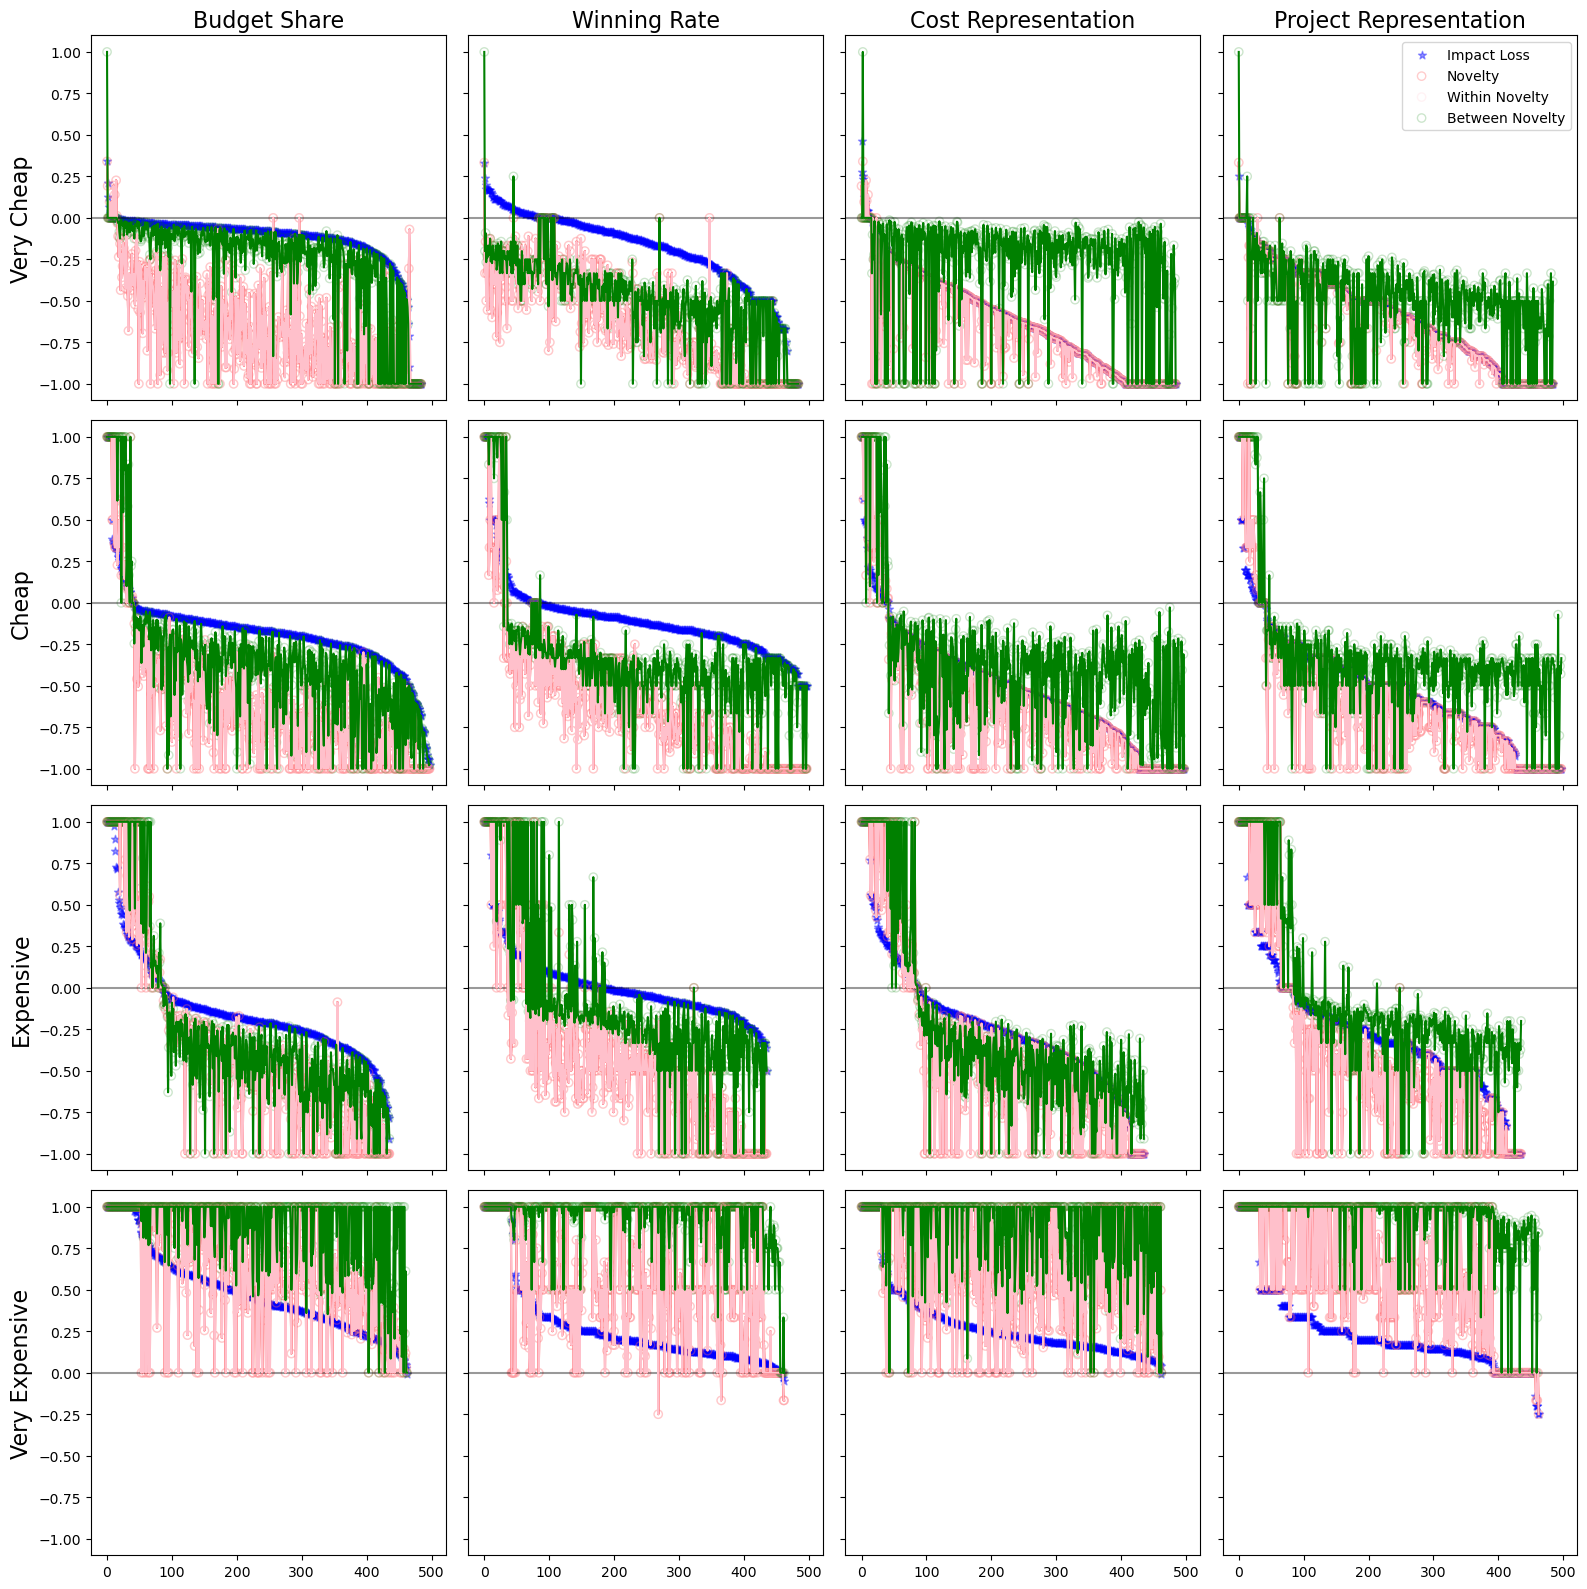

In [29]:
# Plotting 9 x 4 plots; for each of the 9 categories, 4 different plots
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)

## for First Quartile (Very Cheap)
first_quartile_bs_plot_df = first_quartile_bs_df[['election_id', 'diff_greedy_mes_relative_winners_cost_pct_first_quartile', 'diff_go_mo_relative_winners_cost_pct_first_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_winners_cost_pct_first_quartile', ascending=False).reset_index()
first_quartile_wr_plot_df = first_quartile_wr_df[['election_id', 'diff_greedy_mes_relative_winners_count_pct_first_quartile', 'diff_go_mo_relative_winners_count_pct_first_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_winners_count_pct_first_quartile', ascending=False).reset_index()
first_quartile_cr_plot_df = first_quartile_cr_df[['election_id', 'diff_greedy_mes_relative_proposals_cost_pct_first_quartile', 'diff_go_mo_relative_proposals_cost_pct_first_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_proposals_cost_pct_first_quartile', ascending=False).reset_index()
first_quartile_pr_plot_df = first_quartile_pr_df[['election_id', 'diff_greedy_mes_relative_proposals_count_pct_first_quartile', 'diff_go_mo_relative_proposals_count_pct_first_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_proposals_count_pct_first_quartile', ascending=False).reset_index()

axes[0][0].axhline(y=0, color='black', alpha=0.4)
axes[0][0].scatter(range(len(first_quartile_bs_plot_df)), first_quartile_bs_plot_df['diff_greedy_mes_relative_winners_cost_pct_first_quartile'],  marker='*', facecolors='blue', alpha=0.4, color='blue')
axes[0][0].scatter(range(len(first_quartile_bs_plot_df)), first_quartile_bs_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[0][0].plot(range(len(first_quartile_bs_plot_df)), first_quartile_bs_plot_df['novelty_impact_rate'], color='red')
axes[0][0].scatter(range(len(first_quartile_bs_plot_df)), first_quartile_bs_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[0][0].plot(range(len(first_quartile_bs_plot_df)), first_quartile_bs_plot_df['within_novelty'], color='pink')
axes[0][0].scatter(range(len(first_quartile_bs_plot_df)), first_quartile_bs_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[0][0].plot(range(len(first_quartile_bs_plot_df)), first_quartile_bs_plot_df['between_novelty'], color='green')
axes[0][0].set_title('Budget Share', fontsize=16)
axes[0][0].set_ylabel('Very Cheap', fontsize=16)

axes[0][1].axhline(y=0, color='black', alpha=0.4)
axes[0][1].scatter(range(len(first_quartile_wr_plot_df)), first_quartile_wr_plot_df['diff_greedy_mes_relative_winners_count_pct_first_quartile'], marker='*', facecolors='blue', alpha=0.4, color='blue')
axes[0][1].scatter(range(len(first_quartile_wr_plot_df)), first_quartile_wr_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[0][1].plot(range(len(first_quartile_wr_plot_df)), first_quartile_wr_plot_df['novelty_impact_rate'], color='red')
axes[0][1].scatter(range(len(first_quartile_wr_plot_df)), first_quartile_wr_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[0][1].plot(range(len(first_quartile_wr_plot_df)), first_quartile_wr_plot_df['within_novelty'], color='pink')
axes[0][1].scatter(range(len(first_quartile_wr_plot_df)), first_quartile_wr_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[0][1].plot(range(len(first_quartile_wr_plot_df)), first_quartile_wr_plot_df['between_novelty'], color='green')
axes[0][1].set_title('Winning Rate', fontsize=16)

axes[0][2].axhline(y=0, color='black', alpha=0.4)
axes[0][2].scatter(range(len(first_quartile_cr_plot_df)), first_quartile_cr_plot_df['diff_greedy_mes_relative_proposals_cost_pct_first_quartile'], marker='*', facecolor='blue', alpha=0.4, color='blue')
axes[0][2].scatter(range(len(first_quartile_cr_plot_df)), first_quartile_cr_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[0][2].plot(range(len(first_quartile_cr_plot_df)), first_quartile_cr_plot_df['novelty_impact_rate'], color='red')
axes[0][2].scatter(range(len(first_quartile_cr_plot_df)), first_quartile_cr_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[0][2].plot(range(len(first_quartile_cr_plot_df)), first_quartile_cr_plot_df['within_novelty'], color='pink')
axes[0][2].scatter(range(len(first_quartile_cr_plot_df)), first_quartile_cr_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[0][2].plot(range(len(first_quartile_cr_plot_df)), first_quartile_cr_plot_df['between_novelty'], color='green')
axes[0][2].set_title('Cost Representation', fontsize=16)

axes[0][3].axhline(y=0, color='black', alpha=0.4)
axes[0][3].scatter(range(len(first_quartile_pr_plot_df)), first_quartile_pr_plot_df['diff_greedy_mes_relative_proposals_count_pct_first_quartile'], label='Impact Loss', marker='*', facecolor='blue', alpha=0.4, color='blue')
axes[0][3].scatter(range(len(first_quartile_pr_plot_df)), first_quartile_pr_plot_df['novelty_impact_rate'], label='Novelty', marker='o', facecolors='none', alpha=0.2, color='red')
axes[0][3].plot(range(len(first_quartile_pr_plot_df)), first_quartile_pr_plot_df['novelty_impact_rate'], color='red')
axes[0][3].scatter(range(len(first_quartile_pr_plot_df)), first_quartile_pr_plot_df['within_novelty'], label='Within Novelty', marker='o', facecolors='none', alpha=0.2, color='pink')
axes[0][3].plot(range(len(first_quartile_pr_plot_df)), first_quartile_pr_plot_df['within_novelty'], color='pink')
axes[0][3].scatter(range(len(first_quartile_pr_plot_df)), first_quartile_pr_plot_df['between_novelty'], label='Between Novelty', marker='o', facecolors='none', alpha=0.2, color='green')
axes[0][3].plot(range(len(first_quartile_pr_plot_df)), first_quartile_pr_plot_df['between_novelty'], color='green')
axes[0][3].legend()
axes[0][3].set_title('Project Representation', fontsize=16)

## for Second Quartile (Cheap)
second_quartile_bs_plot_df = second_quartile_bs_df[['election_id', 'diff_greedy_mes_relative_winners_cost_pct_second_quartile', 'diff_go_mo_relative_winners_cost_pct_second_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_winners_cost_pct_second_quartile', ascending=False).reset_index()
second_quartile_wr_plot_df = second_quartile_wr_df[['election_id', 'diff_greedy_mes_relative_winners_count_pct_second_quartile', 'diff_go_mo_relative_winners_count_pct_second_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_winners_count_pct_second_quartile', ascending=False).reset_index()
second_quartile_cr_plot_df = second_quartile_cr_df[['election_id', 'diff_greedy_mes_relative_proposals_cost_pct_second_quartile', 'diff_go_mo_relative_proposals_cost_pct_second_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_proposals_cost_pct_second_quartile', ascending=False).reset_index()
second_quartile_pr_plot_df = second_quartile_pr_df[['election_id', 'diff_greedy_mes_relative_proposals_count_pct_second_quartile', 'diff_go_mo_relative_proposals_count_pct_second_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_proposals_count_pct_second_quartile', ascending=False).reset_index()

axes[1][0].axhline(y=0, color='black', alpha=0.4)
axes[1][0].scatter(range(len(second_quartile_bs_plot_df)), second_quartile_bs_plot_df['diff_greedy_mes_relative_winners_cost_pct_second_quartile'],  marker='*', facecolors='blue', alpha=0.4, color='blue')
axes[1][0].scatter(range(len(second_quartile_bs_plot_df)), second_quartile_bs_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[1][0].plot(range(len(second_quartile_bs_plot_df)), second_quartile_bs_plot_df['novelty_impact_rate'], color='red')
axes[1][0].scatter(range(len(second_quartile_bs_plot_df)), second_quartile_bs_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[1][0].plot(range(len(second_quartile_bs_plot_df)), second_quartile_bs_plot_df['within_novelty'], color='pink')
axes[1][0].scatter(range(len(second_quartile_bs_plot_df)), second_quartile_bs_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[1][0].plot(range(len(second_quartile_bs_plot_df)), second_quartile_bs_plot_df['between_novelty'], color='green')
axes[1][0].set_ylabel('Cheap', fontsize=16)

axes[1][1].axhline(y=0, color='black', alpha=0.4)
axes[1][1].scatter(range(len(second_quartile_wr_plot_df)), second_quartile_wr_plot_df['diff_greedy_mes_relative_winners_count_pct_second_quartile'], marker='*', facecolors='blue', alpha=0.4, color='blue')
axes[1][1].scatter(range(len(second_quartile_wr_plot_df)), second_quartile_wr_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[1][1].plot(range(len(second_quartile_wr_plot_df)), second_quartile_wr_plot_df['novelty_impact_rate'], color='red')
axes[1][1].scatter(range(len(second_quartile_wr_plot_df)), second_quartile_wr_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[1][1].plot(range(len(second_quartile_wr_plot_df)), second_quartile_wr_plot_df['within_novelty'], color='pink')
axes[1][1].scatter(range(len(second_quartile_wr_plot_df)), second_quartile_wr_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[1][1].plot(range(len(second_quartile_wr_plot_df)), second_quartile_wr_plot_df['between_novelty'], color='green')

axes[1][2].axhline(y=0, color='black', alpha=0.4)
axes[1][2].scatter(range(len(second_quartile_cr_plot_df)), second_quartile_cr_plot_df['diff_greedy_mes_relative_proposals_cost_pct_second_quartile'], marker='*', facecolor='blue', alpha=0.4, color='blue')
axes[1][2].scatter(range(len(second_quartile_cr_plot_df)), second_quartile_cr_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[1][2].plot(range(len(second_quartile_cr_plot_df)), second_quartile_cr_plot_df['novelty_impact_rate'], color='red')
axes[1][2].scatter(range(len(second_quartile_cr_plot_df)), second_quartile_cr_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[1][2].plot(range(len(second_quartile_cr_plot_df)), second_quartile_cr_plot_df['within_novelty'], color='pink')
axes[1][2].scatter(range(len(second_quartile_cr_plot_df)), second_quartile_cr_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[1][2].plot(range(len(second_quartile_cr_plot_df)), second_quartile_cr_plot_df['between_novelty'], color='green')

axes[1][3].axhline(y=0, color='black', alpha=0.4)
axes[1][3].scatter(range(len(second_quartile_pr_plot_df)), second_quartile_pr_plot_df['diff_greedy_mes_relative_proposals_count_pct_second_quartile'], label='Impact Loss', marker='*', facecolor='blue', alpha=0.4, color='blue')
axes[1][3].scatter(range(len(second_quartile_pr_plot_df)), second_quartile_pr_plot_df['novelty_impact_rate'], label='Novelty', marker='o', facecolors='none', alpha=0.2, color='red')
axes[1][3].plot(range(len(second_quartile_pr_plot_df)), second_quartile_pr_plot_df['novelty_impact_rate'], color='red')
axes[1][3].scatter(range(len(second_quartile_pr_plot_df)), second_quartile_pr_plot_df['within_novelty'], label='Novelty', marker='o', facecolors='none', alpha=0.2, color='pink')
axes[1][3].plot(range(len(second_quartile_pr_plot_df)), second_quartile_pr_plot_df['within_novelty'], color='pink')
axes[1][3].scatter(range(len(second_quartile_pr_plot_df)), second_quartile_pr_plot_df['between_novelty'], label='Novelty', marker='o', facecolors='none', alpha=0.2, color='green')
axes[1][3].plot(range(len(second_quartile_pr_plot_df)), second_quartile_pr_plot_df['between_novelty'], color='green')

## for Third Quartile (Expensive)
third_quartile_bs_plot_df = third_quartile_bs_df[['election_id', 'diff_greedy_mes_relative_winners_cost_pct_third_quartile', 'diff_go_mo_relative_winners_cost_pct_third_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_winners_cost_pct_third_quartile', ascending=False).reset_index()
third_quartile_wr_plot_df = third_quartile_wr_df[['election_id', 'diff_greedy_mes_relative_winners_count_pct_third_quartile', 'diff_go_mo_relative_winners_count_pct_third_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_winners_count_pct_third_quartile', ascending=False).reset_index()
third_quartile_cr_plot_df = third_quartile_cr_df[['election_id', 'diff_greedy_mes_relative_proposals_cost_pct_third_quartile', 'diff_go_mo_relative_proposals_cost_pct_third_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_proposals_cost_pct_third_quartile', ascending=False).reset_index()
third_quartile_pr_plot_df = third_quartile_pr_df[['election_id', 'diff_greedy_mes_relative_proposals_count_pct_third_quartile', 'diff_go_mo_relative_proposals_count_pct_third_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_proposals_count_pct_third_quartile', ascending=False).reset_index()

axes[2][0].axhline(y=0, color='black', alpha=0.4)
axes[2][0].scatter(range(len(third_quartile_bs_plot_df)), third_quartile_bs_plot_df['diff_greedy_mes_relative_winners_cost_pct_third_quartile'],  marker='*', facecolors='blue', alpha=0.4, color='blue')
axes[2][0].scatter(range(len(third_quartile_bs_plot_df)), third_quartile_bs_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[2][0].plot(range(len(third_quartile_bs_plot_df)), third_quartile_bs_plot_df['novelty_impact_rate'], color='red')
axes[2][0].scatter(range(len(third_quartile_bs_plot_df)), third_quartile_bs_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[2][0].plot(range(len(third_quartile_bs_plot_df)), third_quartile_bs_plot_df['within_novelty'], color='pink')
axes[2][0].scatter(range(len(third_quartile_bs_plot_df)), third_quartile_bs_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[2][0].plot(range(len(third_quartile_bs_plot_df)), third_quartile_bs_plot_df['between_novelty'], color='green')
axes[2][0].set_ylabel('Expensive', fontsize=16)

axes[2][1].axhline(y=0, color='black', alpha=0.4)
axes[2][1].scatter(range(len(third_quartile_wr_plot_df)), third_quartile_wr_plot_df['diff_greedy_mes_relative_winners_count_pct_third_quartile'], marker='*', facecolors='blue', alpha=0.4, color='blue')
axes[2][1].scatter(range(len(third_quartile_wr_plot_df)), third_quartile_wr_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[2][1].plot(range(len(third_quartile_wr_plot_df)), third_quartile_wr_plot_df['novelty_impact_rate'], color='red')
axes[2][1].scatter(range(len(third_quartile_wr_plot_df)), third_quartile_wr_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[2][1].plot(range(len(third_quartile_wr_plot_df)), third_quartile_wr_plot_df['within_novelty'], color='pink')
axes[2][1].scatter(range(len(third_quartile_wr_plot_df)), third_quartile_wr_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[2][1].plot(range(len(third_quartile_wr_plot_df)), third_quartile_wr_plot_df['between_novelty'], color='green')

axes[2][2].axhline(y=0, color='black', alpha=0.4)
axes[2][2].scatter(range(len(third_quartile_cr_plot_df)), third_quartile_cr_plot_df['diff_greedy_mes_relative_proposals_cost_pct_third_quartile'], marker='*', facecolor='blue', alpha=0.4, color='blue')
axes[2][2].scatter(range(len(third_quartile_cr_plot_df)), third_quartile_cr_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[2][2].plot(range(len(third_quartile_cr_plot_df)), third_quartile_cr_plot_df['novelty_impact_rate'], color='red')
axes[2][2].scatter(range(len(third_quartile_cr_plot_df)), third_quartile_cr_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[2][2].plot(range(len(third_quartile_cr_plot_df)), third_quartile_cr_plot_df['within_novelty'], color='pink')
axes[2][2].scatter(range(len(third_quartile_cr_plot_df)), third_quartile_cr_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[2][2].plot(range(len(third_quartile_cr_plot_df)), third_quartile_cr_plot_df['between_novelty'], color='green')

axes[2][3].axhline(y=0, color='black', alpha=0.4)
axes[2][3].scatter(range(len(third_quartile_pr_plot_df)), third_quartile_pr_plot_df['diff_greedy_mes_relative_proposals_count_pct_third_quartile'], label='Impact Loss', marker='*', facecolor='blue', alpha=0.4, color='blue')
axes[2][3].scatter(range(len(third_quartile_pr_plot_df)), third_quartile_pr_plot_df['novelty_impact_rate'], label='Novelty', marker='o', facecolors='none', alpha=0.2, color='red')
axes[2][3].plot(range(len(third_quartile_pr_plot_df)), third_quartile_pr_plot_df['novelty_impact_rate'], color='red')
axes[2][3].scatter(range(len(third_quartile_pr_plot_df)), third_quartile_pr_plot_df['within_novelty'], label='Novelty', marker='o', facecolors='none', alpha=0.2, color='pink')
axes[2][3].plot(range(len(third_quartile_pr_plot_df)), third_quartile_pr_plot_df['within_novelty'], color='pink')
axes[2][3].scatter(range(len(third_quartile_pr_plot_df)), third_quartile_pr_plot_df['between_novelty'], label='Novelty', marker='o', facecolors='none', alpha=0.2, color='green')
axes[2][3].plot(range(len(third_quartile_pr_plot_df)), third_quartile_pr_plot_df['between_novelty'], color='green')

## for Fourth Quartile (Very Expensive)
fourth_quartile_bs_plot_df = fourth_quartile_bs_df[['election_id', 'diff_greedy_mes_relative_winners_cost_pct_fourth_quartile', 'diff_go_mo_relative_winners_cost_pct_fourth_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_winners_cost_pct_fourth_quartile', ascending=False).reset_index()
fourth_quartile_wr_plot_df = fourth_quartile_wr_df[['election_id', 'diff_greedy_mes_relative_winners_count_pct_fourth_quartile', 'diff_go_mo_relative_winners_count_pct_fourth_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_winners_count_pct_fourth_quartile', ascending=False).reset_index()
fourth_quartile_cr_plot_df = fourth_quartile_cr_df[['election_id', 'diff_greedy_mes_relative_proposals_cost_pct_fourth_quartile', 'diff_go_mo_relative_proposals_cost_pct_fourth_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_proposals_cost_pct_fourth_quartile', ascending=False).reset_index()
fourth_quartile_pr_plot_df = fourth_quartile_pr_df[['election_id', 'diff_greedy_mes_relative_proposals_count_pct_fourth_quartile', 'diff_go_mo_relative_proposals_count_pct_fourth_quartile', 'novelty_impact_rate', 'within_novelty', 'between_novelty']].sort_values(by='diff_greedy_mes_relative_proposals_count_pct_fourth_quartile', ascending=False).reset_index()

axes[3][0].axhline(y=0, color='black', alpha=0.4)
axes[3][0].scatter(range(len(fourth_quartile_bs_plot_df)), fourth_quartile_bs_plot_df['diff_greedy_mes_relative_winners_cost_pct_fourth_quartile'],  marker='*', facecolors='blue', alpha=0.4, color='blue')
axes[3][0].scatter(range(len(fourth_quartile_bs_plot_df)), fourth_quartile_bs_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[3][0].plot(range(len(fourth_quartile_bs_plot_df)), fourth_quartile_bs_plot_df['novelty_impact_rate'], color='red')
axes[3][0].scatter(range(len(fourth_quartile_bs_plot_df)), fourth_quartile_bs_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[3][0].plot(range(len(fourth_quartile_bs_plot_df)), fourth_quartile_bs_plot_df['within_novelty'], color='pink')
axes[3][0].scatter(range(len(fourth_quartile_bs_plot_df)), fourth_quartile_bs_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[3][0].plot(range(len(fourth_quartile_bs_plot_df)), fourth_quartile_bs_plot_df['between_novelty'], color='green')
axes[3][0].set_ylabel('Very Expensive', fontsize=16)

axes[3][1].axhline(y=0, color='black', alpha=0.4)
axes[3][1].scatter(range(len(fourth_quartile_wr_plot_df)), fourth_quartile_wr_plot_df['diff_greedy_mes_relative_winners_count_pct_fourth_quartile'], marker='*', facecolors='blue', alpha=0.4, color='blue')
axes[3][1].scatter(range(len(fourth_quartile_wr_plot_df)), fourth_quartile_wr_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[3][1].plot(range(len(fourth_quartile_wr_plot_df)), fourth_quartile_wr_plot_df['novelty_impact_rate'], color='red')
axes[3][1].scatter(range(len(fourth_quartile_wr_plot_df)), fourth_quartile_wr_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[3][1].plot(range(len(fourth_quartile_wr_plot_df)), fourth_quartile_wr_plot_df['within_novelty'], color='pink')
axes[3][1].scatter(range(len(fourth_quartile_wr_plot_df)), fourth_quartile_wr_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[3][1].plot(range(len(fourth_quartile_wr_plot_df)), fourth_quartile_wr_plot_df['between_novelty'], color='green')

axes[3][2].axhline(y=0, color='black', alpha=0.4)
axes[3][2].scatter(range(len(fourth_quartile_cr_plot_df)), fourth_quartile_cr_plot_df['diff_greedy_mes_relative_proposals_cost_pct_fourth_quartile'], marker='*', facecolor='blue', alpha=0.4, color='blue')
axes[3][2].scatter(range(len(fourth_quartile_cr_plot_df)), fourth_quartile_cr_plot_df['novelty_impact_rate'], marker='o', facecolors='none', alpha=0.2, color='red')
axes[3][2].plot(range(len(fourth_quartile_cr_plot_df)), fourth_quartile_cr_plot_df['novelty_impact_rate'], color='red')
axes[3][2].scatter(range(len(fourth_quartile_cr_plot_df)), fourth_quartile_cr_plot_df['within_novelty'], marker='o', facecolors='none', alpha=0.2, color='pink')
axes[3][2].plot(range(len(fourth_quartile_cr_plot_df)), fourth_quartile_cr_plot_df['within_novelty'], color='pink')
axes[3][2].scatter(range(len(fourth_quartile_cr_plot_df)), fourth_quartile_cr_plot_df['between_novelty'], marker='o', facecolors='none', alpha=0.2, color='green')
axes[3][2].plot(range(len(fourth_quartile_cr_plot_df)), fourth_quartile_cr_plot_df['between_novelty'], color='green')

axes[3][3].axhline(y=0, color='black', alpha=0.4)
axes[3][3].scatter(range(len(fourth_quartile_pr_plot_df)), fourth_quartile_pr_plot_df['diff_greedy_mes_relative_proposals_count_pct_fourth_quartile'], label='Impact Loss', marker='*', facecolor='blue', alpha=0.4, color='blue')
axes[3][3].scatter(range(len(fourth_quartile_pr_plot_df)), fourth_quartile_pr_plot_df['novelty_impact_rate'], label='Novelty', marker='o', facecolors='none', alpha=0.2, color='red')
axes[3][3].plot(range(len(fourth_quartile_pr_plot_df)), fourth_quartile_pr_plot_df['novelty_impact_rate'], color='red')
axes[3][3].scatter(range(len(fourth_quartile_pr_plot_df)), fourth_quartile_pr_plot_df['within_novelty'], label='Novelty', marker='o', facecolors='none', alpha=0.2, color='pink')
axes[3][3].plot(range(len(fourth_quartile_pr_plot_df)), fourth_quartile_pr_plot_df['within_novelty'], color='pink')
axes[3][3].scatter(range(len(fourth_quartile_pr_plot_df)), fourth_quartile_pr_plot_df['between_novelty'], label='Novelty', marker='o', facecolors='none', alpha=0.2, color='green')
axes[3][3].plot(range(len(fourth_quartile_pr_plot_df)), fourth_quartile_pr_plot_df['between_novelty'], color='green')

plt.tight_layout()
plt.show()

In [30]:
# introducing additional columns to plot into bar plots
def assignNoveltyLossColumn(row):
    row['novelty_loss'] = abs(row['novelty_impact_rate']) if row['novelty_impact_rate'] > 0 else float('nan')
    return row['novelty_loss']
    
def assignNoveltyGainColumn(row):
    row['novelty_gain'] = abs(row['novelty_impact_rate']) if row['novelty_impact_rate'] < 0 else float('nan')
    return row['novelty_gain']

# introducing additional columns to plot into bar plots
def assignWithinNoveltyLossColumn(row):
    row['within_novelty_loss'] = abs(row['within_novelty']) if row['within_novelty'] > 0 else float('nan')
    return row['within_novelty_loss']
    
def assignWithinNoveltyGainColumn(row):
    row['within_novelty_gain'] = abs(row['within_novelty']) if row['within_novelty'] < 0 else float('nan')
    return row['within_novelty_gain']

def assignBetweenNoveltyLossColumn(row):
    row['between_novelty_loss'] = abs(row['between_novelty']) if row['between_novelty'] > 0 else float('nan')
    return row['between_novelty_loss']
    
def assignBetweenNoveltyGainColumn(row):
    row['between_novelty_gain'] = abs(row['between_novelty']) if row['between_novelty'] < 0 else float('nan')
    return row['between_novelty_gain']

within_novelty_cost_avg_map = {}
within_novelty_count_avg_map = {}
between_novelty_cost_avg_map = {}
between_novelty_count_avg_map = {}

## for very cheap projects; first quartile
first_quartile_bs_df['within_novelty_loss'] = first_quartile_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
first_quartile_bs_df['within_novelty_gain'] = first_quartile_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
first_quartile_bs_df['between_novelty_loss'] = first_quartile_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
first_quartile_bs_df['between_novelty_gain'] = first_quartile_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

first_quartile_wr_df['within_novelty_loss'] = first_quartile_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
first_quartile_wr_df['within_novelty_gain'] = first_quartile_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
first_quartile_wr_df['between_novelty_loss'] = first_quartile_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
first_quartile_wr_df['between_novelty_gain'] = first_quartile_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

first_quartile_cr_df['within_novelty_loss'] = first_quartile_cr_df.apply(assignWithinNoveltyLossColumn, axis=1)
first_quartile_cr_df['within_novelty_gain'] = first_quartile_cr_df.apply(assignWithinNoveltyGainColumn, axis=1)
first_quartile_cr_df['between_novelty_loss'] = first_quartile_cr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
first_quartile_cr_df['between_novelty_gain'] = first_quartile_cr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

first_quartile_pr_df['within_novelty_loss'] = first_quartile_pr_df.apply(assignWithinNoveltyLossColumn, axis=1)
first_quartile_pr_df['within_novelty_gain'] = first_quartile_pr_df.apply(assignWithinNoveltyGainColumn, axis=1)
first_quartile_pr_df['between_novelty_loss'] = first_quartile_pr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
first_quartile_pr_df['between_novelty_gain'] = first_quartile_pr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['first_quartile'] = round(first_quartile_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['first_quartile'] = round(first_quartile_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['first_quartile'] = round(first_quartile_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['first_quartile'] = round(first_quartile_wr_df['between_novelty'].mean(), 2)


## for cheap projects; second quartile
second_quartile_bs_df['within_novelty_loss'] = second_quartile_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
second_quartile_bs_df['within_novelty_gain'] = second_quartile_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
second_quartile_bs_df['between_novelty_loss'] = second_quartile_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
second_quartile_bs_df['between_novelty_gain'] = second_quartile_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

second_quartile_wr_df['within_novelty_loss'] = second_quartile_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
second_quartile_wr_df['within_novelty_gain'] = second_quartile_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
second_quartile_wr_df['between_novelty_loss'] = second_quartile_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
second_quartile_wr_df['between_novelty_gain'] = second_quartile_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

second_quartile_cr_df['within_novelty_loss'] = second_quartile_cr_df.apply(assignWithinNoveltyLossColumn, axis=1)
second_quartile_cr_df['within_novelty_gain'] = second_quartile_cr_df.apply(assignWithinNoveltyGainColumn, axis=1)
second_quartile_cr_df['between_novelty_loss'] = second_quartile_cr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
second_quartile_cr_df['between_novelty_gain'] = second_quartile_cr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

second_quartile_pr_df['within_novelty_loss'] = second_quartile_pr_df.apply(assignWithinNoveltyLossColumn, axis=1)
second_quartile_pr_df['within_novelty_gain'] = second_quartile_pr_df.apply(assignWithinNoveltyGainColumn, axis=1)
second_quartile_pr_df['between_novelty_loss'] = second_quartile_pr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
second_quartile_pr_df['between_novelty_gain'] = second_quartile_pr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['second_quartile'] = round(second_quartile_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['second_quartile'] = round(second_quartile_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['second_quartile'] = round(second_quartile_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['second_quartile'] = round(second_quartile_wr_df['between_novelty'].mean(), 2)

# ## for expensive projects; third quartile
third_quartile_bs_df['within_novelty_loss'] = third_quartile_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
third_quartile_bs_df['within_novelty_gain'] = third_quartile_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
third_quartile_bs_df['between_novelty_loss'] = third_quartile_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
third_quartile_bs_df['between_novelty_gain'] = third_quartile_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

third_quartile_wr_df['within_novelty_loss'] = third_quartile_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
third_quartile_wr_df['within_novelty_gain'] = third_quartile_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
third_quartile_wr_df['between_novelty_loss'] = third_quartile_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
third_quartile_wr_df['between_novelty_gain'] = third_quartile_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

third_quartile_cr_df['within_novelty_loss'] = third_quartile_cr_df.apply(assignWithinNoveltyLossColumn, axis=1)
third_quartile_cr_df['within_novelty_gain'] = third_quartile_cr_df.apply(assignWithinNoveltyGainColumn, axis=1)
third_quartile_cr_df['between_novelty_loss'] = third_quartile_cr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
third_quartile_cr_df['between_novelty_gain'] = third_quartile_cr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

third_quartile_pr_df['within_novelty_loss'] = third_quartile_pr_df.apply(assignWithinNoveltyLossColumn, axis=1)
third_quartile_pr_df['within_novelty_gain'] = third_quartile_pr_df.apply(assignWithinNoveltyGainColumn, axis=1)
third_quartile_pr_df['between_novelty_loss'] = third_quartile_pr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
third_quartile_pr_df['between_novelty_gain'] = third_quartile_pr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['third_quartile'] = round(third_quartile_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['third_quartile'] = round(third_quartile_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['third_quartile'] = round(third_quartile_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['third_quartile'] = round(third_quartile_wr_df['between_novelty'].mean(), 2)

## for very expensive projects; fourth quartile
fourth_quartile_bs_df['within_novelty_loss'] = fourth_quartile_bs_df.apply(assignWithinNoveltyLossColumn, axis=1)
fourth_quartile_bs_df['within_novelty_gain'] = fourth_quartile_bs_df.apply(assignWithinNoveltyGainColumn, axis=1)
fourth_quartile_bs_df['between_novelty_loss'] = fourth_quartile_bs_df.apply(assignBetweenNoveltyLossColumn, axis=1)
fourth_quartile_bs_df['between_novelty_gain'] = fourth_quartile_bs_df.apply(assignBetweenNoveltyGainColumn, axis=1)

fourth_quartile_wr_df['within_novelty_loss'] = fourth_quartile_wr_df.apply(assignWithinNoveltyLossColumn, axis=1)
fourth_quartile_wr_df['within_novelty_gain'] = fourth_quartile_wr_df.apply(assignWithinNoveltyGainColumn, axis=1)
fourth_quartile_wr_df['between_novelty_loss'] = fourth_quartile_wr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
fourth_quartile_wr_df['between_novelty_gain'] = fourth_quartile_wr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

fourth_quartile_cr_df['within_novelty_loss'] = fourth_quartile_cr_df.apply(assignWithinNoveltyLossColumn, axis=1)
fourth_quartile_cr_df['within_novelty_gain'] = fourth_quartile_cr_df.apply(assignWithinNoveltyGainColumn, axis=1)
fourth_quartile_cr_df['between_novelty_loss'] = fourth_quartile_cr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
fourth_quartile_cr_df['between_novelty_gain'] = fourth_quartile_cr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

fourth_quartile_pr_df['within_novelty_loss'] = fourth_quartile_pr_df.apply(assignWithinNoveltyLossColumn, axis=1)
fourth_quartile_pr_df['within_novelty_gain'] = fourth_quartile_pr_df.apply(assignWithinNoveltyGainColumn, axis=1)
fourth_quartile_pr_df['between_novelty_loss'] = fourth_quartile_pr_df.apply(assignBetweenNoveltyLossColumn, axis=1)
fourth_quartile_pr_df['between_novelty_gain'] = fourth_quartile_pr_df.apply(assignBetweenNoveltyGainColumn, axis=1)

within_novelty_cost_avg_map['fourth_quartile'] = round(fourth_quartile_bs_df['within_novelty'].mean(), 2)
between_novelty_cost_avg_map['fourth_quartile'] = round(fourth_quartile_bs_df['between_novelty'].mean(), 2)
within_novelty_count_avg_map['fourth_quartile'] = round(fourth_quartile_wr_df['within_novelty'].mean(), 2)
between_novelty_count_avg_map['fourth_quartile'] = round(fourth_quartile_wr_df['between_novelty'].mean(), 2)

## Box plot across all four cost levels and across all 4 metrics with valid datasets

### Preparing meleted dataset for budget share

In [31]:
# preparing budget share melted data
budget_share_data = pd.DataFrame()

bs_first_quartile = first_quartile_bs_df[['cost_quartile', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
bs_second_quartile = second_quartile_bs_df[['cost_quartile', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
bs_third_quartile = third_quartile_bs_df[['cost_quartile', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
bs_fourth_quartile = fourth_quartile_bs_df[['cost_quartile', 'mes_bs', 'ug_bs', 'excl_mes_bs', 'excl_ug_bs', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]

# v2 doesn't consist of budget shares scores for es, ug and their exclusive versions
bs_first_quartile_v2 = first_quartile_bs_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
bs_second_quartile_v2 = second_quartile_bs_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
bs_third_quartile_v2 = third_quartile_bs_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
bs_fourth_quartile_v2 = fourth_quartile_bs_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]

budget_share_data = pd.concat([budget_share_data, bs_first_quartile_v2], ignore_index=True)
budget_share_data = pd.concat([budget_share_data, bs_second_quartile_v2], ignore_index=True)
budget_share_data = pd.concat([budget_share_data, bs_third_quartile_v2], ignore_index=True)
budget_share_data = pd.concat([budget_share_data, bs_fourth_quartile_v2], ignore_index=True)

# I renamed it here only because I want to use the label in the superplot with other metrics; not necessary to rename in others
budget_share_data.rename(columns={
    'ug_bs': 'UG',
    'mes_bs': 'ES',
    'excl_ug_bs': 'UG [Exclusive]',
    'excl_mes_bs': 'ES [Exclusive]',
    'within_novelty_loss': 'Within Novelty Loss',
    'within_novelty_gain': 'Within Novelty Gain',
    'between_novelty_loss': 'Between Novelty Loss',
    'between_novelty_gain': 'Between Novelty Gain'
}, inplace=True)

melted_budget_share_data = pd.melt(budget_share_data, id_vars=['cost_quartile'], var_name='Winning Type', value_name='Budget Share')
melted_budget_share_data.shape


(7528, 3)

In [32]:
# preparing winning rate melted data
winning_rate_data = pd.DataFrame()

wr_first_quartile = first_quartile_wr_df[['cost_quartile', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
wr_second_quartile = second_quartile_wr_df[['cost_quartile', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
wr_third_quartile = third_quartile_wr_df[['cost_quartile', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
wr_fourth_quartile = fourth_quartile_wr_df[['cost_quartile', 'mes_wr', 'ug_wr', 'excl_mes_wr', 'excl_ug_wr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]

wr_first_quartile_v2 = first_quartile_wr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
wr_second_quartile_v2 = second_quartile_wr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
wr_third_quartile_v2 = third_quartile_wr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
wr_fourth_quartile_v2 = fourth_quartile_wr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]

winning_rate_data = pd.concat([winning_rate_data, wr_first_quartile_v2], ignore_index=True)
winning_rate_data = pd.concat([winning_rate_data, wr_second_quartile_v2], ignore_index=True)
winning_rate_data = pd.concat([winning_rate_data, wr_third_quartile_v2], ignore_index=True)
winning_rate_data = pd.concat([winning_rate_data, wr_fourth_quartile_v2], ignore_index=True)

melted_winning_rate_data = pd.melt(winning_rate_data, id_vars=['cost_quartile'], var_name='Winning Type', value_name='Winning Rate')
melted_winning_rate_data.shape

(7528, 3)

In [33]:
# preparing cost representation melted data
cost_representation_data = pd.DataFrame()

cr_first_quartile = first_quartile_cr_df[['cost_quartile', 'mes_cr', 'ug_cr', 'excl_mes_cr', 'excl_ug_cr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cr_second_quartile = second_quartile_cr_df[['cost_quartile', 'mes_cr', 'ug_cr', 'excl_mes_cr', 'excl_ug_cr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cr_third_quartile = third_quartile_cr_df[['cost_quartile', 'mes_cr', 'ug_cr', 'excl_mes_cr', 'excl_ug_cr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cr_fourth_quartile = fourth_quartile_cr_df[['cost_quartile', 'mes_cr', 'ug_cr', 'excl_mes_cr', 'excl_ug_cr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]

cr_first_quartile_v2 = first_quartile_cr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cr_second_quartile_v2 = second_quartile_cr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cr_third_quartile_v2 = third_quartile_cr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
cr_fourth_quartile_v2 = fourth_quartile_cr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]

cost_representation_data = pd.concat([cost_representation_data, cr_first_quartile_v2], ignore_index=True)
cost_representation_data = pd.concat([cost_representation_data, cr_second_quartile_v2], ignore_index=True)
cost_representation_data = pd.concat([cost_representation_data, cr_third_quartile_v2], ignore_index=True)
cost_representation_data = pd.concat([cost_representation_data, cr_fourth_quartile_v2], ignore_index=True)

melted_cost_representation_data = pd.melt(cost_representation_data, id_vars=['cost_quartile'], var_name='Winning Type', value_name='Cost Representation')
melted_cost_representation_data.shape

(7528, 3)

In [34]:
# preparing project representation melted data
project_representation_data = pd.DataFrame()

pr_first_quartile = first_quartile_pr_df[['cost_quartile', 'mes_pr', 'ug_pr', 'excl_mes_pr', 'excl_ug_pr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
pr_second_quartile = second_quartile_pr_df[['cost_quartile', 'mes_pr', 'ug_pr', 'excl_mes_pr', 'excl_ug_pr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
pr_third_quartile = third_quartile_pr_df[['cost_quartile', 'mes_pr', 'ug_pr', 'excl_mes_pr', 'excl_ug_pr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
pr_fourth_quartile = fourth_quartile_pr_df[['cost_quartile', 'mes_pr', 'ug_pr', 'excl_mes_pr', 'excl_ug_pr', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]

pr_first_quartile_v2 = first_quartile_pr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
pr_second_quartile_v2 = second_quartile_pr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
pr_third_quartile_v2 = third_quartile_pr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]
pr_fourth_quartile_v2 = fourth_quartile_pr_df[['cost_quartile', 'within_novelty_loss', 'within_novelty_gain', 'between_novelty_loss', 'between_novelty_gain']]

project_representation_data = pd.concat([project_representation_data, pr_first_quartile_v2], ignore_index=True)
project_representation_data = pd.concat([project_representation_data, pr_second_quartile_v2], ignore_index=True)
project_representation_data = pd.concat([project_representation_data, pr_third_quartile_v2], ignore_index=True)
project_representation_data = pd.concat([project_representation_data, pr_fourth_quartile_v2], ignore_index=True)

melted_project_representation_data = pd.melt(project_representation_data, id_vars=['cost_quartile'], var_name='Winning Type', value_name='Project Representation')
melted_project_representation_data.shape

(7528, 3)

## Box plot for all 4 cost level across 4 metrics

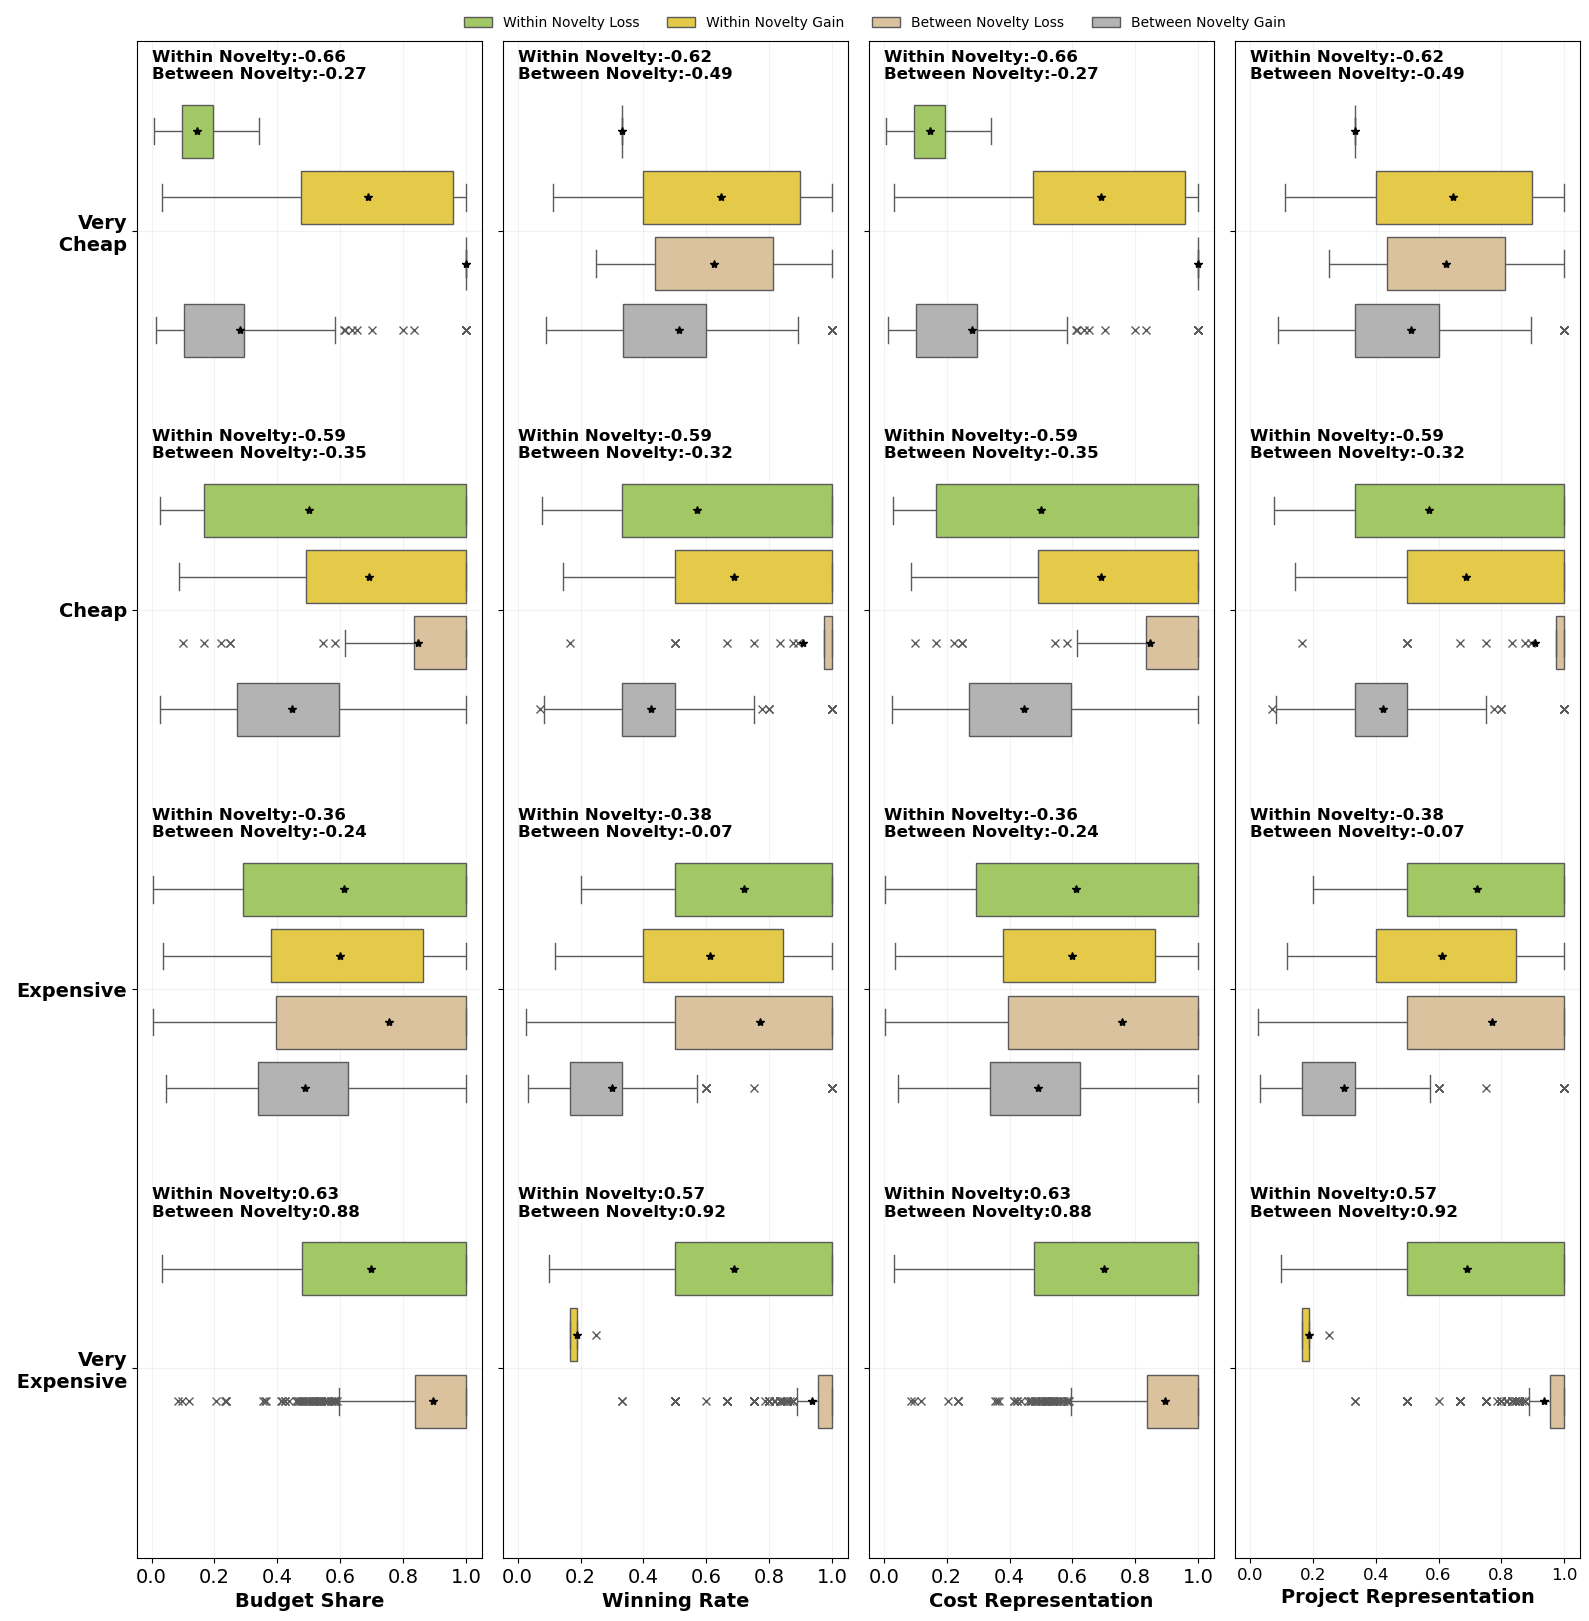

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(16, 16), sharex=True, sharey=True)

novelty_color_palette = ['#a6d854','#ffd92f','#e5c494','#b3b3b3']

sns.boxplot(y='cost_quartile', ax=axes[0], x='Budget Share', hue='Winning Type', data=melted_budget_share_data, showmeans=True, medianprops={'visible': False}, flierprops={"marker": "x"}, width=0.7, meanprops={"marker": '*', "markerfacecolor":"black", "markeredgecolor":"black"}, palette=novelty_color_palette, dodge=True, gap=0.2)
sns.boxplot(y='cost_quartile', ax=axes[1], x='Winning Rate', hue='Winning Type', data=melted_winning_rate_data, showmeans=True, medianprops={'visible': False}, flierprops={"marker": "x"}, width=0.7, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"}, palette=novelty_color_palette, dodge=True, gap=0.2)
sns.boxplot(y='cost_quartile', ax=axes[2], x='Cost Representation', hue='Winning Type', data=melted_cost_representation_data, showmeans=True, medianprops={'visible': False}, flierprops={"marker": "x"}, width=0.7, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"}, palette=novelty_color_palette, dodge=True, gap=0.2)
sns.boxplot(y='cost_quartile', ax=axes[3], x='Project Representation', hue='Winning Type', data=melted_project_representation_data, showmeans=True, medianprops={'visible': False}, flierprops={"marker": "x"}, width=0.7, meanprops={"marker":"*", "markerfacecolor":"black", "markeredgecolor":"black"}, palette=novelty_color_palette, dodge=True, gap=0.2)

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[3].set_ylabel('')

axes[0].set_xlabel('Budget Share', fontsize=14, fontdict={'fontweight': 'bold'})
axes[1].set_xlabel('Winning Rate', fontsize=14, fontdict={'fontweight': 'bold'})
axes[2].set_xlabel('Cost Representation', fontsize=14, fontdict={'fontweight': 'bold'})
axes[3].set_xlabel('Project Representation', fontsize=14, fontdict={'fontweight': 'bold'})

axes[0].tick_params(axis='both', labelsize=14)
axes[1].tick_params(axis='both', labelsize=14)
axes[2].tick_params(axis='both', labelsize=14)
axes[3].tick_params(axis='both', labelsize=14)

axes[0].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[1].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[2].grid(axis='both', which='major', color='gray', alpha=0.1)
axes[3].grid(axis='both', which='major', color='gray', alpha=0.1)

# Customize legend
handles, labels = axes[0].get_legend_handles_labels()

# Create legend outside of the main plot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.55, 0.99), ncols=8, frameon=False)
fig.subplots_adjust(right=1)  # Adjust right side to fit legend

# Text overlay for overall novelty average of in between and within novelties
for idx, ((within_cost_key, within_cost_value), (between_cost_key, between_cost_value)) in enumerate(zip(within_novelty_cost_avg_map.items(), between_novelty_cost_avg_map.items())):
    if(within_cost_key == between_cost_key):
        axes[0].text(0, idx - 0.4, f'Within Novelty:{within_cost_value}\nBetween Novelty:{between_cost_value}', fontsize=12, fontdict={'fontweight': 'bold'})
        axes[2].text(0, idx - 0.4, f'Within Novelty:{within_cost_value}\nBetween Novelty:{between_cost_value}', fontsize=12, fontdict={'fontweight': 'bold'})

for idx, ((within_count_key, within_count_value), (between_count_key, between_count_value)) in enumerate(zip(within_novelty_count_avg_map.items(), between_novelty_count_avg_map.items())):
    if(within_count_key == between_count_key):
        axes[1].text(0, idx - 0.4, f'Within Novelty:{within_count_value}\nBetween Novelty:{between_count_value}', fontsize=12, fontdict={'fontweight': 'bold'})
        axes[3].text(0, idx - 0.4, f'Within Novelty:{within_count_value}\nBetween Novelty:{between_count_value}', fontsize=12, fontdict={'fontweight': 'bold'})

axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)
axes[2].legend().set_visible(False)
axes[3].legend().set_visible(False)


plt.xticks(np.arange(0, 1.2, 0.2), fontsize=12)
labels = axes[0].get_yticklabels()

# Set bold font for y-labels
for label in labels:
    label.set_fontweight('bold')
plt.tight_layout()
plt.show()